# Gran Enciclopèdia Catalana (GEC). USER ANALYSIS
***

After the data analysis and processing and the clusterization of the consumption data of GEC, we perform a further study based on users. We have 2,475 unique users in the data-set (5% of them containing the 75% of the visits). 

---

We divide our study into the following stages:

    1. First, we create a new data-set of users (instead of visits/consumptions) using as columns the information of 
    the consumption clusters (number of visits of each user in C1, C2 or C3) and the day of the week (Monday-Sunday). 
    
    2. Afterwards, we study the frequency of users in each consumption cluster using different kind of plots and statistics.
    
    3. Then, we clusterize the users using the DBSCAN Algorithm. We found 2 groups of users. We give an interpretation to 
    the clusters with different plots and statistics.
    
    4. Finally, we use the inter-event time of each user for the clustering


    
***


# INDEX

    0. Create new Data-Frame for users
    
    1. Frequency of users
        1.1. Frequency of users (all-data)
        1.2. Frequency of users in each cluster
            1.2.1. Plot for each cluster
            1.2.2. Plot for each cluster (normalized by cluster size)
            1.2.3. Single plot including all clusters
        1.3. Scatter plot for each cluster pair. Pearson correlation
        1.4. Scatter plot for each cluster pair (Normalized by cluster size)
        1.5. Plot all-sorted users of each cluster
        1.6. Common users in clusters
        
    2. Clustering users. DBSCAN Algorithm
        2.1. Pre-processing. Standarization
        2.2. DBSCAN Algorithm
            2.2.1. Determine minPts and ε
            2.2.2. DBSCAN Algorithm with k=2
        2.3. Clustering interpretation (DBSCAN)
            2.3.1. Plot number of visits per user 
            2.3.2. Users cluster versus consumption cluster
            2.3.3. Users cluster versus weekday
            
    3. Disparity measure
    
    4. Inter-event time
        4.1. Inter-event time per consumption cluster
        4.2. Inter-event time temporal series per user
        4.3. DBSCAN algorithm using inter-event time
        4.4. Clustering interpretation
            4.4.1. Users in each DBSCAN cluster 
            4.4.2. Mean inter-event time and standard deviation of each user
            4.4.3.  Mean inter-event time and standard deviation of each DBSCAN cluster

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from kmodes.kprototypes import KPrototypes
from scipy.optimize import curve_fit
import seaborn as sns


####  Read the csv-file with the consumption data and the clustering information

We read the csv file with the clustering results of the 114,597 consumption units. Apart from the 4 columns that characterize the visits (URL, User ID, Day of the week and Hour of the day) there are 3 extra columns with the following information:

    1. hour of the day in seconds. Considering the origin in the beginning of the day (00h) 
    2. Cluster labels: 0, 1 and 2
    3. Segment (Cluster labels):  C1, C2 and C3
    

In [3]:
df = pd.read_csv("dades_consum_gec_clusters_3.csv")   # Read the csv file with the clustering information
df

,url_visitada,id_usuari,day,data_de_consulta2,Cluster labels,Segment,data_de_consulta
0,https://www.enciclopedia.cat/,10451,Sunday,2021.0,0,C1,2022-05-15 00:33:41
1,https://www.enciclopedia.cat/cerca/gec?search_...,10451,Sunday,2033.0,0,C1,2022-05-15 00:33:53
2,https://www.enciclopedia.cat/catalunya-romanic...,10451,Sunday,2054.0,0,C1,2022-05-15 00:34:14
3,https://www.enciclopedia.cat/cerca/gec?search_...,10451,Sunday,2061.0,0,C1,2022-05-15 00:34:21
4,https://www.enciclopedia.cat/catalunya-romanic...,10451,Sunday,2066.0,0,C1,2022-05-15 00:34:26
...,...,...,...,...,...,...,...
114592,https://www.enciclopedia.cat/,37174,Monday,85271.0,2,C3,2022-11-21 23:41:11
114593,https://www.enciclopedia.cat/catalunya-romanic...,37174,Monday,85310.0,2,C3,2022-11-21 23:41:50
114594,https://www.enciclopedia.cat/user/37174,37174,Monday,85316.0,2,C3,2022-11-21 23:41:56
114595,https://www.enciclopedia.cat/user/37174/edit,37174,Monday,85329.0,2,C3,2022-11-21 23:42:09


# 0. Create new Data-Frame for users

For each unique user, we count the absolut frequency of visits/records in each cluster and on each weekday. We create a new Data-Frame which contain the following 17 columns:  

    - ID user:  The ID of the unique USER
    - C1: the number of counts of the user in the cluster C1
    - C2: the number of counts of the user in the cluster C2
    - C3: the number of counts of the user in the cluster C3
    - max count: the maximum number of counts between the four clusters
    - max label: the label of the cluster with the maximum number of counts (C1, C2, C3 or C4)
    - min count: the minimum number of counts between the four clusters
    - min label: the label of the cluster with the minimum number of counts (C1, C2, C3 or C4)
    - 7 columns with the counts of each user in each weekday: Monday, Tuesday,...,Sunday
    - Total counts: The total records/visits of each user
    - Code: is the code (rank) of each user depending on the number of visits (1 for the most frequent and so on)
    
The data-set is then sorted by the total number of visits of each user (from most frequent user to less frequent).

#### For each user, we count the number of visits in each consumption cluster and in each day of the week

In [4]:
c1_counts=[]
c2_counts=[]
c3_counts=[]
usuari_id=[]
user_max_counts_cluster=[]
user_max_label_cluster=[]
user_min_counts_cluster=[]
user_min_label_cluster=[]
dilluns_counts=[]
dimarts_counts=[]
dimecres_counts=[]
dijous_counts=[]
divendres_counts=[]
dissabte_counts=[]
diumenge_counts=[]

for i,j in df.groupby('id_usuari'):        # Group the data-frame by unique users
    
    print('User:',i)
    print('')
    
    clusters= ['C1','C2','C3']   
    dies=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    
    print(j['Segment'].value_counts(sort=False).reindex(clusters[::-1], fill_value=0)[['C1','C2','C3']])
    print('')
    print(j['day'].value_counts(sort=False).reindex(dies[::-1], fill_value=0)[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']])
    print('')
    print('----------')
    print('')
    
    # Count the number of visits in each cluster (for each user) in order: C1, C2, C3 and C4.
    values = j['Segment'].value_counts(sort=False).reindex(clusters[::-1], fill_value=0)[['C1','C2','C3']].keys().tolist()
    counts = j['Segment'].value_counts(sort=False).reindex(clusters[::-1], fill_value=0)[['C1','C2','C3']].tolist()
    
    usuari_id.append(i)
    c1_counts.append(counts[0])    # Append the number of visits in each cluster into lists in order to add as new columns.
    c2_counts.append(counts[1])
    c3_counts.append(counts[2])     
    user_max_counts_cluster.append(max(counts))
    user_min_counts_cluster.append(min(counts))
    index_max=counts.index(max(counts))
    index_min=counts.index(min(counts))
    user_max_label_cluster.append(values[index_max])
    user_min_label_cluster.append(values[index_min])
    
    
    # The same proceed for the weekday.
    counts_dies = j['day'].value_counts(sort=False).reindex(dies[::-1], fill_value=0)[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']].tolist()
    dilluns_counts.append(counts_dies[0])
    dimarts_counts.append(counts_dies[1])
    dimecres_counts.append(counts_dies[2])    
    dijous_counts.append(counts_dies[3])
    divendres_counts.append(counts_dies[4])
    dissabte_counts.append(counts_dies[5])
    diumenge_counts.append(counts_dies[6])

User: 863

C1    11818
C2     5791
C3      561
Name: Segment, dtype: int64

Monday       2909
Tuesday      4260
Wednesday    4740
Thursday     3401
Friday       2860
Saturday        0
Sunday          0
Name: day, dtype: int64

----------

User: 1444

C1    3
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       3
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 1504

C1    2491
C2    1531
C3      82
Name: Segment, dtype: int64

Monday        675
Tuesday       725
Wednesday    1149
Thursday     1013
Friday        539
Saturday        0
Sunday          3
Name: day, dtype: int64

----------

User: 3064

C1    184
C2    138
C3     25
Name: Segment, dtype: int64

Monday        78
Tuesday       29
Wednesday     47
Thursday     134
Friday        41
Saturday      18
Sunday         0
Name: day, dtype: int64

----------

User: 3422

C1    267
C2     71
C3    166
Name: Segment, dtype: int64

Monday        98
Tu


User: 5212

C1     0
C2     0
C3    17
Name: Segment, dtype: int64

Monday       15
Tuesday       0
Wednesday     0
Thursday      2
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 5263

C1     0
C2    12
C3     0
Name: Segment, dtype: int64

Monday       12
Tuesday       0
Wednesday     0
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 5281

C1    6
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    6
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 5341

C1    0
C2    3
C3    5
Name: Segment, dtype: int64

Monday       0
Tuesday      3
Wednesday    0
Thursday     5
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 5390

C1     0
C2     0
C3    21
Name: Segment, dtype: int64

Monday        0
Tuesday      21
Wednesday     0
Thursday      0
Friday        0
Sat

Name: Segment, dtype: int64

Monday        2
Tuesday       0
Wednesday    16
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 7694

C1     0
C2    18
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday      18
Wednesday     0
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 7730

C1    0
C2    0
C3    6
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       6
Name: day, dtype: int64

----------

User: 7757

C1    0
C2    0
C3    4
Name: Segment, dtype: int64

Monday       0
Tuesday      4
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 7797

C1    0
C2    0
C3    4
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    4
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int

Name: day, dtype: int64

----------

User: 9752

C1    32
C2     0
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday       5
Wednesday     5
Thursday      3
Friday        0
Saturday      8
Sunday       11
Name: day, dtype: int64

----------

User: 9815

C1    0
C2    6
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    6
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 9832

C1    122
C2     11
C3      5
Name: Segment, dtype: int64

Monday       19
Tuesday      15
Wednesday    13
Thursday     29
Friday       30
Saturday     12
Sunday       20
Name: day, dtype: int64

----------

User: 9905

C1    47
C2    51
C3     1
Name: Segment, dtype: int64

Monday        0
Tuesday      14
Wednesday    60
Thursday     18
Friday        7
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 9932

C1    0
C2    3
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesd

Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    5
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 11916

C1    9
C2    0
C3    0
Name: Segment, dtype: int64

Monday       9
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 11973

C1     1
C2     2
C3    37
Name: Segment, dtype: int64

Monday        3
Tuesday       1
Wednesday     2
Thursday      0
Friday        3
Saturday     25
Sunday        6
Name: day, dtype: int64

----------

User: 12017

C1    6
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     6
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 12024

C1    48
C2    53
C3     0
Name: Segment, dtype: int64

Monday       17
Tuesday      22
Wednesday    25
Thursday     21
Friday       16
Saturday      0
Sunday        0
Name: day, dty

User: 13725

C1    0
C2    5
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     5
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 13744

C1    123
C2     19
C3     31
Name: Segment, dtype: int64

Monday        0
Tuesday       6
Wednesday    50
Thursday     54
Friday       57
Saturday      6
Sunday        0
Name: day, dtype: int64

----------

User: 13765

C1    16
C2     0
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday     16
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 13891

C1    12
C2     0
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday      12
Wednesday     0
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 13896

C1    6
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      4
Wednesday    1
Thursday     1
Friday   

User: 15028

C1    0
C2    0
C3    4
Name: Segment, dtype: int64

Monday       0
Tuesday      4
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 15030

C1     0
C2     8
C3    39
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     4
Thursday      0
Friday        0
Saturday      0
Sunday       43
Name: day, dtype: int64

----------

User: 15034

C1    0
C2    0
C3    4
Name: Segment, dtype: int64

Monday       4
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 15039

C1    4
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       4
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 15080

C1    0
C2    0
C3    5
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Su

User: 16604

C1    58
C2    58
C3    10
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday    38
Thursday     50
Friday       34
Saturday      4
Sunday        0
Name: day, dtype: int64

----------

User: 16657

C1     0
C2     0
C3    10
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    4
Thursday     0
Friday       4
Saturday     2
Sunday       0
Name: day, dtype: int64

----------

User: 16787

C1    565
C2    126
C3     27
Name: Segment, dtype: int64

Monday       119
Tuesday      125
Wednesday    151
Thursday     193
Friday        72
Saturday      22
Sunday        36
Name: day, dtype: int64

----------

User: 16845

C1    4
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      4
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 16932

C1    18
C2    30
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday      23
Wednesday     7
Thursday      9
Fr

Name: day, dtype: int64

----------

User: 18286

C1     3
C2    49
C3     3
Name: Segment, dtype: int64

Monday       52
Tuesday       1
Wednesday     2
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 18321

C1    24
C2     7
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday      0
Friday       31
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 18403

C1    0
C2    0
C3    6
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    6
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 18426

C1    6
C2    5
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      5
Wednesday    0
Thursday     6
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 18439

C1     1
C2    20
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday      21
Wednesday 

User: 20333

C1    10
C2     0
C3     0
Name: Segment, dtype: int64

Monday       10
Tuesday       0
Wednesday     0
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 20339

C1     5
C2    29
C3     3
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday    16
Thursday     12
Friday        9
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 20340

C1     15
C2      0
C3    403
Name: Segment, dtype: int64

Monday       120
Tuesday      133
Wednesday     46
Thursday       0
Friday        54
Saturday      15
Sunday        50
Name: day, dtype: int64

----------

User: 20341

C1    0
C2    4
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       4
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 20345

C1    103
C2     82
C3     49
Name: Segment, dtype: int64

Monday       51
Tuesday      11
Wednesday    28
Thursday

User: 21110

C1    0
C2    3
C3    5
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       8
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 21111

C1     0
C2     1
C3    52
Name: Segment, dtype: int64

Monday        2
Tuesday       7
Wednesday     4
Thursday     34
Friday        0
Saturday      6
Sunday        0
Name: day, dtype: int64

----------

User: 21113

C1    0
C2    0
C3    1
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     1
Sunday       0
Name: day, dtype: int64

----------

User: 21118

C1    15
C2     0
C3     0
Name: Segment, dtype: int64

Monday       3
Tuesday      8
Wednesday    0
Thursday     0
Friday       4
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 21124

C1     52
C2    168
C3     98
Name: Segment, dtype: int64

Monday        47
Tuesday       19
Wednesday     62
Thursday     117
Friday        3

User: 22546

C1    43
C2     6
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday       6
Wednesday    41
Thursday      0
Friday        2
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 22547

C1    17
C2     5
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday       2
Wednesday    17
Thursday      0
Friday        3
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 22550

C1    4
C2    0
C3    3
Name: Segment, dtype: int64

Monday       4
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       3
Name: day, dtype: int64

----------

User: 22579

C1    90
C2    22
C3     0
Name: Segment, dtype: int64

Monday        9
Tuesday      25
Wednesday     3
Thursday     64
Friday       11
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 22613

C1    20
C2    15
C3    19
Name: Segment, dtype: int64

Monday       22
Tuesday       6
Wednesday     2
Thursday     11
Frida

User: 24509

C1    1
C2    5
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      5
Wednesday    0
Thursday     1
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 24520

C1     0
C2    24
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday      24
Wednesday     0
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 24522

C1     0
C2     5
C3    35
Name: Segment, dtype: int64

Monday       25
Tuesday      15
Wednesday     0
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 24526

C1     38
C2     93
C3    303
Name: Segment, dtype: int64

Monday       246
Tuesday       93
Wednesday      0
Thursday       9
Friday        23
Saturday      26
Sunday        37
Name: day, dtype: int64

----------

User: 24533

C1    0
C2    0
C3    7
Name: Segment, dtype: int64

Monday       0
Tuesday      7
Wednesday    0
Thursday     0
Fr

Name: day, dtype: int64

----------

User: 24747

C1    0
C2    6
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       6
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 24801

C1    0
C2    0
C3    4
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       4
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 25009

C1    7
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     7
Sunday       0
Name: day, dtype: int64

----------

User: 25019

C1     4
C2    16
C3    13
Name: Segment, dtype: int64

Monday        2
Tuesday       0
Wednesday     0
Thursday      0
Friday        0
Saturday     25
Sunday        6
Name: day, dtype: int64

----------

User: 25030

C1    1
C2    2
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday  

Name: day, dtype: int64

----------

User: 26083

C1    3
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    3
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 26087

C1     2
C2     1
C3    15
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday    17
Thursday      0
Friday        1
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 26096

C1    0
C2    0
C3    4
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    4
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 26102

C1     1
C2    18
C3     4
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday    23
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 26103

C1    1
C2    9
C3    0
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday    

C1    0
C2    0
C3    8
Name: Segment, dtype: int64

Monday       8
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 26753

C1    0
C2    0
C3    2
Name: Segment, dtype: int64

Monday       2
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 26762

C1    0
C2    0
C3    6
Name: Segment, dtype: int64

Monday       6
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 26781

C1    0
C2    0
C3    4
Name: Segment, dtype: int64

Monday       4
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 26790

C1    0
C2    0
C3    4
Name: Segment, dtype: int64

Monday       4
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day,


----------

User: 27263

C1     0
C2     0
C3    10
Name: Segment, dtype: int64

Monday       1
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     4
Sunday       5
Name: day, dtype: int64

----------

User: 27264

C1    0
C2    0
C3    8
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     8
Sunday       0
Name: day, dtype: int64

----------

User: 27265

C1     0
C2     0
C3    11
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday      0
Friday        0
Saturday     11
Sunday        0
Name: day, dtype: int64

----------

User: 27266

C1    0
C2    0
C3    5
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     5
Sunday       0
Name: day, dtype: int64

----------

User: 27268

C1     0
C2     3
C3    15
Name: Segment, dtype: int64

Monday        4
Tuesday       0
Wednesday     0
Thursday      0
Friday   

Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    7
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 28392

C1    4
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     4
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 28393

C1    15
C2     0
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday     15
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 28395

C1    1
C2    3
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     4
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 28396

C1    1
C2    2
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     3
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64


Name: day, dtype: int64

----------

User: 28741

C1    0
C2    2
C3    4
Name: Segment, dtype: int64

Monday       6
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 28744

C1     0
C2    15
C3    18
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday     33
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 28749

C1    0
C2    2
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      2
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 28762

C1    0
C2    3
C3    9
Name: Segment, dtype: int64

Monday       12
Tuesday       0
Wednesday     0
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 28763

C1    0
C2    0
C3    5
Name: Segment, dtype: int64

Monday       5
Tuesday      0
Wednesday    0
Thu

User: 29378

C1     4
C2    58
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday      36
Wednesday    20
Thursday      3
Friday        3
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 29380

C1     2
C2    13
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday     15
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 29384

C1    2
C2    2
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     4
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 29385

C1    6
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     1
Friday       5
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 29387

C1    0
C2    5
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     5
Friday       0
Saturda

User: 29654

C1    0
C2    0
C3    4
Name: Segment, dtype: int64

Monday       4
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 29656

C1     0
C2     0
C3    10
Name: Segment, dtype: int64

Monday       10
Tuesday       0
Wednesday     0
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 29657

C1    0
C2    0
C3    5
Name: Segment, dtype: int64

Monday       5
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 29658

C1    0
C2    0
C3    9
Name: Segment, dtype: int64

Monday       9
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 29661

C1    0
C2    0
C3    3
Name: Segment, dtype: int64

Monday       3
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Su

Name: day, dtype: int64

----------

User: 30374

C1    166
C2     66
C3    157
Name: Segment, dtype: int64

Monday       50
Tuesday      84
Wednesday    67
Thursday     74
Friday       87
Saturday     27
Sunday        0
Name: day, dtype: int64

----------

User: 30375

C1    4
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      4
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 30376

C1    5
C2    6
C3    0
Name: Segment, dtype: int64

Monday        0
Tuesday      10
Wednesday     1
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 30377

C1    11
C2     0
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday      11
Wednesday     0
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 30378

C1    0
C2    2
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      2
Wedne

Name: day, dtype: int64

----------

User: 31461

C1     0
C2    10
C3     1
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday    11
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 31462

C1    0
C2    1
C3    1
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    2
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 31463

C1    7
C2    2
C3    9
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    3
Thursday     8
Friday       0
Saturday     7
Sunday       0
Name: day, dtype: int64

----------

User: 31464

C1    0
C2    3
C3    1
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    4
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 31466

C1    0
C2    0
C3    2
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    2
Thursday  


----------

User: 32634

C1    0
C2    0
C3    9
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     9
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 32640

C1     3
C2    26
C3    18
Name: Segment, dtype: int64

Monday        1
Tuesday      21
Wednesday     9
Thursday      0
Friday        0
Saturday      0
Sunday       16
Name: day, dtype: int64

----------

User: 32647

C1    0
C2    1
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      1
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 32653

C1    0
C2    2
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      2
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 32654

C1    1
C2    1
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      1
Wednesday    1
Thursday     0
Friday       0
Satu

Name: day, dtype: int64

----------

User: 33648

C1    0
C2    0
C3    9
Name: Segment, dtype: int64

Monday       0
Tuesday      9
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 33736

C1    2
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    2
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 33738

C1    7
C2    2
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    5
Thursday     4
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 33742

C1    7
C2    0
C3    0
Name: Segment, dtype: int64

Monday       3
Tuesday      0
Wednesday    4
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 33747

C1    20
C2     0
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday    20
Thursday      

User: 34195

C1    1
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       1
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 34207

C1     5
C2    30
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday      30
Wednesday     5
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 34208

C1    0
C2    9
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      9
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 34209

C1     0
C2     8
C3    11
Name: Segment, dtype: int64

Monday        0
Tuesday      19
Wednesday     0
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 34210

C1     8
C2     8
C3    16
Name: Segment, dtype: int64

Monday        0
Tuesday       6
Wednesday    15
Thursday      6
Friday        5

User: 34300

C1     0
C2    11
C3     1
Name: Segment, dtype: int64

Monday        0
Tuesday      12
Wednesday     0
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 34301

C1    0
C2    5
C3    1
Name: Segment, dtype: int64

Monday       0
Tuesday      6
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 34302

C1    0
C2    0
C3    6
Name: Segment, dtype: int64

Monday       0
Tuesday      6
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 34303

C1    0
C2    0
C3    9
Name: Segment, dtype: int64

Monday       0
Tuesday      9
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 34304

C1    3
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    3
Thursday     0
Friday       0
Saturday     0
Su

User: 34356

C1     0
C2     0
C3    14
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday     13
Friday        0
Saturday      1
Sunday        0
Name: day, dtype: int64

----------

User: 34357

C1    6
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       6
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 34358

C1    19
C2    17
C3     0
Name: Segment, dtype: int64

Monday       15
Tuesday       9
Wednesday     0
Thursday      4
Friday        6
Saturday      2
Sunday        0
Name: day, dtype: int64

----------

User: 34359

C1    0
C2    0
C3    5
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       5
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 34360

C1    0
C2    4
C3    1
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturda


----------

User: 34410

C1     1
C2     7
C3    12
Name: Segment, dtype: int64

Monday       13
Tuesday       0
Wednesday     0
Thursday      0
Friday        0
Saturday      7
Sunday        0
Name: day, dtype: int64

----------

User: 34411

C1    0
C2    0
C3    2
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     2
Sunday       0
Name: day, dtype: int64

----------

User: 34412

C1    3
C2    1
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       4
Name: day, dtype: int64

----------

User: 34413

C1    3
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       3
Name: day, dtype: int64

----------

User: 34414

C1     9
C2     0
C3    28
Name: Segment, dtype: int64

Monday        2
Tuesday       7
Wednesday     0
Thursday      0
Friday      

Name: day, dtype: int64

----------

User: 34538

C1    0
C2    9
C3    1
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday     10
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 34539

C1    0
C2    0
C3    7
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     7
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 34540

C1     0
C2     0
C3    12
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday     12
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 34562

C1    6
C2    3
C3    0
Name: Segment, dtype: int64

Monday       1
Tuesday      0
Wednesday    1
Thursday     5
Friday       1
Saturday     1
Sunday       0
Name: day, dtype: int64

----------

User: 34573

C1     8
C2    60
C3    17
Name: Segment, dtype: int64

Monday       15
Tuesday       0
Wednesday    

Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    5
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 34716

C1    8
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    8
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 34717

C1     1
C2    13
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday    14
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 34718

C1     1
C2    12
C3     9
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday    22
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 34719

C1     0
C2    16
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday    16
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name

Name: day, dtype: int64

----------

User: 34792

C1    0
C2    8
C3    0
Name: Segment, dtype: int64

Monday       8
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 34793

C1     0
C2    12
C3     2
Name: Segment, dtype: int64

Monday       11
Tuesday       0
Wednesday     0
Thursday      0
Friday        0
Saturday      0
Sunday        3
Name: day, dtype: int64

----------

User: 34801

C1    1
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      1
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 34806

C1     2
C2     3
C3    10
Name: Segment, dtype: int64

Monday       0
Tuesday      8
Wednesday    0
Thursday     5
Friday       0
Saturday     2
Sunday       0
Name: day, dtype: int64

----------

User: 34828

C1    0
C2    3
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      3
Wednesday    0
Thursda

Name: Segment, dtype: int64

Monday       43
Tuesday       8
Wednesday     0
Thursday      0
Friday        0
Saturday      8
Sunday        0
Name: day, dtype: int64

----------

User: 34934

C1    0
C2    2
C3    6
Name: Segment, dtype: int64

Monday       8
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 34935

C1    0
C2    1
C3    2
Name: Segment, dtype: int64

Monday       3
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 34936

C1    1
C2    3
C3    2
Name: Segment, dtype: int64

Monday       4
Tuesday      2
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 34937

C1    0
C2    0
C3    8
Name: Segment, dtype: int64

Monday       8
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

--

Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday    25
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 34992

C1    16
C2     0
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday    16
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 34993

C1    12
C2     0
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday    12
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 34994

C1    9
C2    1
C3    0
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday    10
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 34995

C1    13
C2     0
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday    13
Thursday      0
Friday        0
Saturday      0
Sunday

Name: Segment, dtype: int64

Monday       6
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 35071

C1    3
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      3
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 35072

C1    11
C2     1
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday      12
Wednesday     0
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 35073

C1    3
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     3
Sunday       0
Name: day, dtype: int64

----------

User: 35079

C1    6
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    6
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64


C1    11
C2     0
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday      0
Friday       11
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 35133

C1     7
C2    11
C3    49
Name: Segment, dtype: int64

Monday       21
Tuesday      10
Wednesday     7
Thursday     10
Friday       10
Saturday      3
Sunday        6
Name: day, dtype: int64

----------

User: 35134

C1    8
C2    4
C3    0
Name: Segment, dtype: int64

Monday       3
Tuesday      0
Wednesday    0
Thursday     0
Friday       9
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 35135

C1     0
C2    11
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday      0
Friday       11
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 35136

C1    0
C2    4
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       4
Saturday  

Name: Segment, dtype: int64

Monday       0
Tuesday      7
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 35196

C1    0
C2    0
C3    3
Name: Segment, dtype: int64

Monday       0
Tuesday      3
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 35197

C1    3
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    3
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 35198

C1    3
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    3
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 35199

C1    2
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    2
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

---------

User: 35257

C1     0
C2     0
C3    34
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday      0
Friday        0
Saturday     32
Sunday        2
Name: day, dtype: int64

----------

User: 35258

C1     1
C2     1
C3    18
Name: Segment, dtype: int64

Monday        1
Tuesday       1
Wednesday     0
Thursday      3
Friday        0
Saturday     15
Sunday        0
Name: day, dtype: int64

----------

User: 35259

C1    3
C2    2
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       5
Name: day, dtype: int64

----------

User: 35260

C1    1
C2    0
C3    1
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       2
Name: day, dtype: int64

----------

User: 35261

C1    4
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturda

User: 35421

C1     0
C2     3
C3    11
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday    11
Thursday      3
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 35422

C1    12
C2     0
C3     5
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     5
Thursday      0
Friday       12
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 35423

C1     0
C2     0
C3    11
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday    11
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 35424

C1    0
C2    0
C3    7
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    7
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 35425

C1    1
C2    0
C3    3
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    3
Thursday     1
Friday      

Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday      0
Friday        0
Saturday     10
Sunday        0
Name: day, dtype: int64

----------

User: 35484

C1    0
C2    0
C3    7
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     7
Sunday       0
Name: day, dtype: int64

----------

User: 35485

C1    0
C2    0
C3    4
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     4
Sunday       0
Name: day, dtype: int64

----------

User: 35486

C1     0
C2     0
C3    38
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday      0
Friday        0
Saturday     38
Sunday        0
Name: day, dtype: int64

----------

User: 35487

C1    0
C2    0
C3    3
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     3
Sunday       0
Name: day, dtype:

Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    5
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 35591

C1    0
C2    0
C3    4
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    4
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 35592

C1    16
C2     0
C3    15
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     3
Thursday     17
Friday       11
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 35593

C1    0
C2    0
C3    7
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    7
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 35594

C1     0
C2     0
C3    10
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday    10
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dty

Name: day, dtype: int64

----------

User: 35656

C1     1
C2     2
C3    11
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     3
Thursday      0
Friday        0
Saturday      0
Sunday       11
Name: day, dtype: int64

----------

User: 35657

C1    0
C2    2
C3    4
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       6
Name: day, dtype: int64

----------

User: 35658

C1     0
C2    31
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday      0
Friday        0
Saturday      0
Sunday       31
Name: day, dtype: int64

----------

User: 35659

C1    0
C2    4
C3    1
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       5
Name: day, dtype: int64

----------

User: 35660

C1    0
C2    0
C3    4
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0


C1    1
C2    7
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      3
Wednesday    0
Thursday     0
Friday       5
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 35930

C1    0
C2    0
C3    3
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       3
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 35931

C1    0
C2    0
C3    9
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       9
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 35933

C1    24
C2     1
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday      0
Friday        0
Saturday     25
Sunday        0
Name: day, dtype: int64

----------

User: 35934

C1    5
C2    6
C3    0
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday      0
Friday        0
Saturday     11
Sunday   

User: 36172

C1    0
C2    2
C3    1
Name: Segment, dtype: int64

Monday       0
Tuesday      3
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 36173

C1     1
C2     0
C3    15
Name: Segment, dtype: int64

Monday        0
Tuesday      10
Wednesday     6
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 36174

C1     0
C2     0
C3    16
Name: Segment, dtype: int64

Monday        0
Tuesday      16
Wednesday     0
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 36175

C1     0
C2     0
C3    19
Name: Segment, dtype: int64

Monday        0
Tuesday      19
Wednesday     0
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 36176

C1     0
C2    10
C3    21
Name: Segment, dtype: int64

Monday        0
Tuesday      20
Wednesday    11
Thursday      0
Frida

User: 36313

C1    0
C2    4
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       4
Name: day, dtype: int64

----------

User: 36314

C1     0
C2    16
C3    15
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday      0
Friday        0
Saturday      0
Sunday       31
Name: day, dtype: int64

----------

User: 36315

C1    0
C2    3
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       3
Name: day, dtype: int64

----------

User: 36316

C1     0
C2     0
C3    68
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday      0
Friday        0
Saturday      0
Sunday       68
Name: day, dtype: int64

----------

User: 36317

C1     0
C2     0
C3    16
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday      0
Friday        0

User: 36361

C1    1
C2    8
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    9
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 36386

C1    0
C2    0
C3    2
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    2
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 36389

C1     0
C2     0
C3    10
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday    10
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 36398

C1    0
C2    0
C3    2
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    2
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 36404

C1    13
C2     0
C3     0
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday     13
Friday        0
Saturday 

User: 36608

C1     0
C2     0
C3    19
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday      0
Friday        0
Saturday      0
Sunday       19
Name: day, dtype: int64

----------

User: 36611

C1     0
C2     0
C3    53
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     4
Thursday      0
Friday       15
Saturday      0
Sunday       34
Name: day, dtype: int64

----------

User: 36625

C1     0
C2     0
C3    30
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday      0
Friday       24
Saturday      0
Sunday        6
Name: day, dtype: int64

----------

User: 36626

C1    0
C2    0
C3    9
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       9
Name: day, dtype: int64

----------

User: 36627

C1     0
C2     0
C3    12
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday     0
Thursday      0
Frida

User: 36723

C1    3
C2    0
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    3
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 36724

C1    0
C2    3
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    3
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 36725

C1     61
C2     23
C3    113
Name: Segment, dtype: int64

Monday         0
Tuesday        0
Wednesday    112
Thursday       1
Friday        84
Saturday       0
Sunday         0
Name: day, dtype: int64

----------

User: 36726

C1    13
C2     5
C3    49
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday    33
Thursday      5
Friday       20
Saturday      9
Sunday        0
Name: day, dtype: int64

----------

User: 36727

C1     0
C2     0
C3    22
Name: Segment, dtype: int64

Monday        0
Tuesday       0
Wednesday    22
Thursday      0
Frida

User: 36938

C1    5
C2    0
C3    9
Name: Segment, dtype: int64

Monday       9
Tuesday      0
Wednesday    5
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 36941

C1    0
C2    0
C3    2
Name: Segment, dtype: int64

Monday       2
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 36942

C1     0
C2     0
C3    10
Name: Segment, dtype: int64

Monday       10
Tuesday       0
Wednesday     0
Thursday      0
Friday        0
Saturday      0
Sunday        0
Name: day, dtype: int64

----------

User: 36944

C1    0
C2    0
C3    3
Name: Segment, dtype: int64

Monday       3
Tuesday      0
Wednesday    0
Thursday     0
Friday       0
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 36945

C1     0
C2     0
C3    10
Name: Segment, dtype: int64

Monday       10
Tuesday       0
Wednesday     0
Thursday      0
Friday        0
Saturday 

Name: Segment, dtype: int64

Monday        1
Tuesday       0
Wednesday     0
Thursday      0
Friday        0
Saturday     11
Sunday        2
Name: day, dtype: int64

----------

User: 37022

C1    1
C2    2
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       3
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 37024

C1    4
C2    4
C3    0
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       8
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 37025

C1    0
C2    6
C3    6
Name: Segment, dtype: int64

Monday       5
Tuesday      0
Wednesday    0
Thursday     0
Friday       7
Saturday     0
Sunday       0
Name: day, dtype: int64

----------

User: 37026

C1    0
C2    0
C3    7
Name: Segment, dtype: int64

Monday       0
Tuesday      0
Wednesday    0
Thursday     0
Friday       7
Saturday     0
Sunday       0
Name: day, dtype: int64

--

#### We create the new users' dataframe which is sorted by the total number of visits of each user in decreasing order

The new data-frame also contains columns of the user_id, the labels and number of counts of the largest and smallest clusters and the total counts.

In [5]:
df_users_clusters=pd.DataFrame()
df_users_clusters['usuari_id']=usuari_id
df_users_clusters['C1']=c1_counts
df_users_clusters['C2']=c2_counts
df_users_clusters['C3']=c3_counts

df_users_clusters['max count']=user_max_counts_cluster
df_users_clusters['max label']=user_max_label_cluster
df_users_clusters['min count']=user_min_counts_cluster
df_users_clusters['min label']=user_min_label_cluster

df_users_clusters['Monday']=dilluns_counts
df_users_clusters['Tuesday']=dimarts_counts
df_users_clusters['Wednesday']=dimecres_counts
df_users_clusters['Thursday']=dijous_counts
df_users_clusters['Friday']=divendres_counts
df_users_clusters['Saturday']=dissabte_counts
df_users_clusters['Sunday']=diumenge_counts

df_users_clusters['total_counts'] = df_users_clusters[['C1', 'C2', 'C3']].astype(float).sum(1)

df_users_clusters_sorted=df_users_clusters.sort_values(by='total_counts',ascending=False)

df_users_clusters_sorted=df_users_clusters_sorted.reset_index(drop=True)

df_users_clusters_sorted['code'] = pd.factorize(df_users_clusters_sorted['usuari_id'])[0] + 1   # Code the users (sorted by frequency) for plot purposes

df_users_clusters_sorted

,usuari_id,C1,C2,C3,max count,max label,min count,min label,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,total_counts,code
0,863,11818,5791,561,11818,C1,561,C3,2909,4260,4740,3401,2860,0,0,18170.0,1
1,20326,1119,8583,0,8583,C2,0,C3,3352,3258,1077,394,1621,0,0,9702.0,2
2,3522,2738,1692,1205,2738,C1,1205,C3,1360,564,1154,1703,853,1,0,5635.0,3
3,21804,2211,1120,1169,2211,C1,1120,C2,668,809,622,823,489,601,488,4500.0,4
4,1504,2491,1531,82,2491,C1,82,C3,675,725,1149,1013,539,0,3,4104.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,34099,0,0,1,1,C3,0,C1,0,0,0,1,0,0,0,1.0,2471
2471,36979,1,0,0,1,C1,0,C2,0,0,1,0,0,0,0,1.0,2472
2472,35358,0,1,0,1,C2,0,C1,0,1,0,0,0,0,0,1.0,2473
2473,25261,0,0,1,1,C3,0,C1,0,0,0,0,0,0,1,1.0,2474


# 1. Frequency of users

## 1.1. Frequency of users (all-data)

We sort the 2475 users by frequency (in decreasing order) and then we represent the number of visits/records of each users. 

We fit the curve with a power-law distribution between the user 15 and 1000. The exponent is -1.05


Power-law fit with the form f(x)=a·b^x between user 15 and 1000
The fit parameters are: a=16054.644215223223 +- 110.22289118541791 and b=-1.0522808960190004 +- 0.001859314835063285


<ipython-input-6-0ae7369048d9>:39: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)


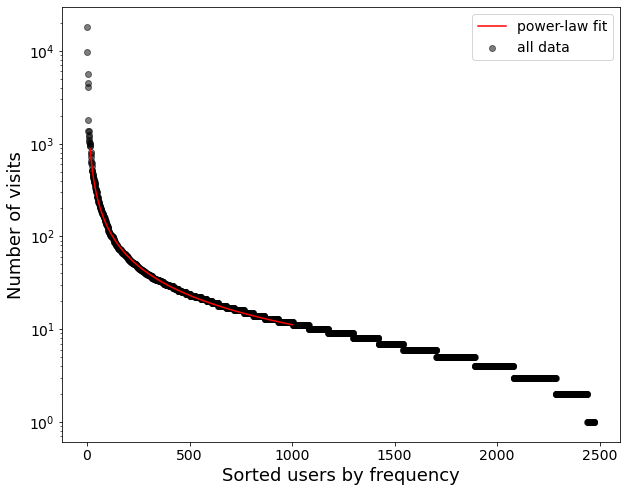

Power-law fit with the form f(x)=a·b^x between user 15 and 1000
The fit parameters are: a=16085.69973097369 +- 126.08009638042223 and b=-1.0528488656760016 +- 0.0021303642005227144


<ipython-input-6-0ae7369048d9>:79: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)


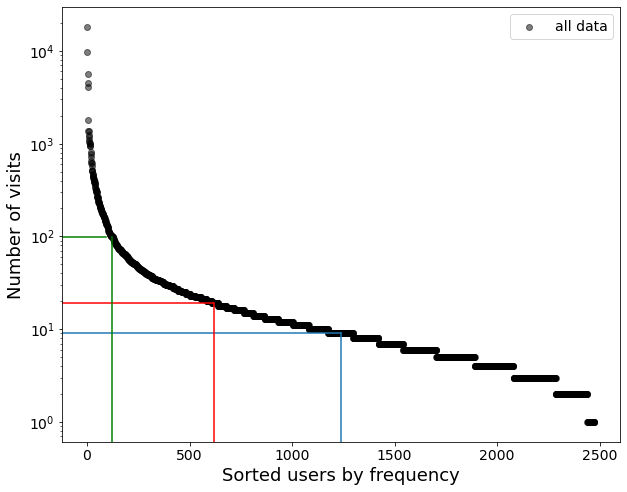

<ipython-input-6-0ae7369048d9>:102: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)


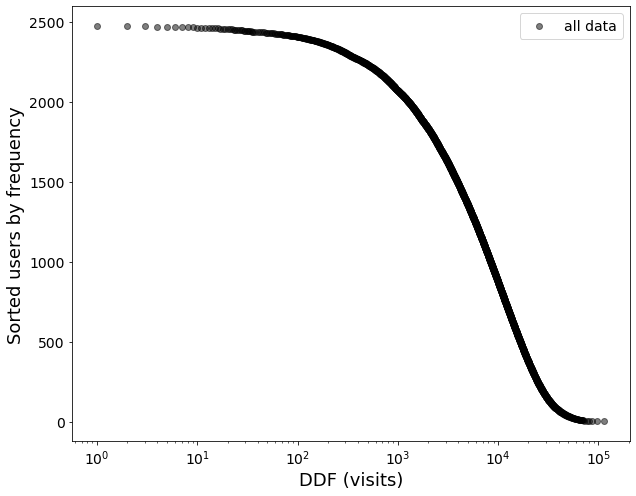

[114597  96427  86725 ...      3      2      1]
q1: 1890.5
q2: 5997.0
q3: 14045.5
q4: 32831.699999999975


In [6]:
def powerlaw(x,a,b):   # Function that returns a power law distribution
    return (a*x**b)
    # POWER-LAW FIT
        
    
values_user = df['id_usuari'].value_counts().keys().tolist()    # count the occurences of each user (sorted by frequency)
counts_user = df['id_usuari'].value_counts().tolist()

# New data-frame with the user ID and the number of counts (sorted)
df_user = pd.DataFrame(            
    {'values': values_user,
     'counts': counts_user
    })

# Code the users (sorted by frequency) for plot purposes
df_user['code'] = pd.factorize(df_user['values'])[0] + 1  



# PLOT. Number of visits of each user
fig, ax1 = plt.subplots(figsize=(10,8)) 

ax1.scatter(df_user['code'], df_user['counts'], label='all data', color='black', alpha=0.5)  

# Power-law fit between user 15 and 1000
code_user=df_user['code'].tolist()
popt, pcov = curve_fit(powerlaw, code_user[15:1000], counts_user[15:1000], p0=(1,-1))
times = np.arange(code_user[15], code_user[1000], 0.01)
model = powerlaw(times, *popt)
perr = np.sqrt(np.diag(pcov))  #calcul error del parametre
ax1.plot(times, model, '-',c='red',label='power-law fit')

print('Power-law fit with the form f(x)=a·b^x between user 15 and 1000')
print('The fit parameters are: a={} +- {} and b={} +- {}'.format(popt[0],perr[0],popt[1],perr[1]))

ax1.set_xlabel('Sorted users by frequency',fontsize=18)
ax1.set_ylabel('Number of visits',fontsize=18)
#ax1.set(xticklabels=[])
ax1.set_yscale('log',basey=10)
#ax1.set_xscale('log',basex=10)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)


plt.show()
    

    
# PLOT. Number of visits of each user, plotting the quantiles
fig, ax1 = plt.subplots(figsize=(10,8)) 

code_user=df_user['code'].tolist()

ax1.scatter( df_user['code'], df_user['counts'],label='all data', color='black', alpha=0.5)  
ax1.axvline(1238,0,0.25) 
ax1.axhline(9,0,0.5)

ax1.axvline(619,0,0.32,color='red')
ax1.axhline(19,0,0.27,color='red')

ax1.axvline(124,0,0.47,color='green')
ax1.axhline(99,0,0.080,color='green')


# Power-law fit between user 15 and 1000
popt, pcov = curve_fit(powerlaw, code_user[15:800], counts_user[15:800], p0=(1,-1))
times = np.arange(code_user[15], code_user[800], 0.01)
model = powerlaw(times, *popt)
perr = np.sqrt(np.diag(pcov))  #calcul error del parametre
#ax1.plot(times, model, '-',c='red',label='power-law fit')

print('Power-law fit with the form f(x)=a·b^x between user 15 and 1000')
print('The fit parameters are: a={} +- {} and b={} +- {}'.format(popt[0],perr[0],popt[1],perr[1]))

ax1.set_xlabel('Sorted users by frequency',fontsize=18)
ax1.set_ylabel('Number of visits',fontsize=18)
#ax1.set(xticklabels=[])
ax1.set_yscale('log',basey=10)
#ax1.set_xscale('log',basex=10)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)


plt.show()



# PLOT. DDF number of visits
fig, ax1 = plt.subplots(figsize=(10,8)) 

sorted_counts_user=np.sort(counts_user)
cdf = np.cumsum(sorted_counts_user)  # Decumulative distribution 
dcdf=cdf[::-1]
ax1.scatter(dcdf,df_user['code'], label='all data', color='black', alpha=0.5)

ax1.set_ylabel('Sorted users by frequency',fontsize=18)
ax1.set_xlabel('DDF (visits)',fontsize=18)
#ax1.set(xticklabels=[])
#ax1.set_yscale('log',basey=10)
ax1.set_xscale('log',basex=10)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)


plt.show()

print(dcdf)

q1_dcdf=np.quantile(dcdf, .25)
q2_dcdf=np.quantile(dcdf, .50)
q3_dcdf=np.quantile(dcdf, .75)
q4_dcdf=np.quantile(dcdf, 0.95)

print('q1:',q1_dcdf)
print('q2:',q2_dcdf)
print('q3:',q3_dcdf)
print('q4:',q4_dcdf)
    



## 1.2. Frequency of users in each cluster

### 1.2.1. Plot for each cluster

Cluster C1 with 44812 records (39.10399050585966%)

The number of unique users in the cluster C1 is 1329
The mean number of visits per user in this cluster is 33.71858540255831 and the standard deviation 350.365908644819
The quantil Q1 (25%) is 3.0 visits
The quantil Q2 (50%) is 6.0 visits
The quantil Q3 (75%) is 14.0 visits
The quantil Q4 (90%) is 31.0 visits

Power-law fit with the form f(x)=a·b^x between users 15 and 400
The fit parameters are: a=4703.734408912729 +- 72.6280248787147 and b=-1.010176661871134 +- 0.004202089381356234


<ipython-input-7-a03c02dcdd3b>:73: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-7-a03c02dcdd3b>:74: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)


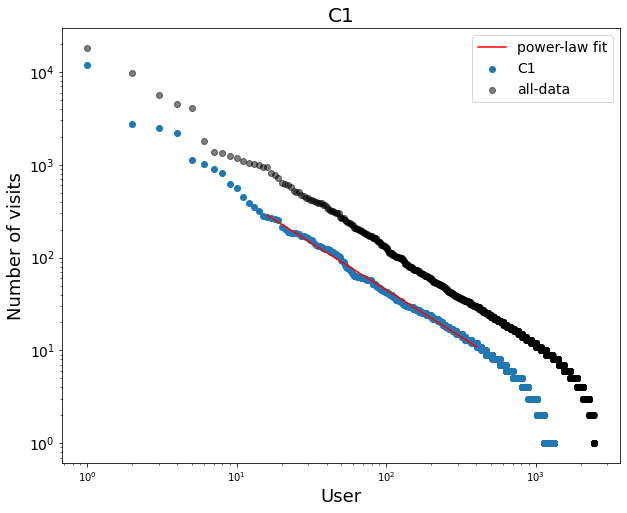



--------------------------


Cluster C2 with 39289 records (34.28449261324467%)

The number of unique users in the cluster C2 is 1148
The mean number of visits per user in this cluster is 34.22386759581882 and the standard deviation 317.0731285884168
The quantil Q1 (25%) is 3.0 visits
The quantil Q2 (50%) is 7.0 visits
The quantil Q3 (75%) is 14.0 visits
The quantil Q4 (90%) is 35.0 visits

Power-law fit with the form f(x)=a·b^x between users 15 and 400
The fit parameters are: a=4079.614309835407 +- 71.26666981063636 and b=-1.0074514273033852 +- 0.004749933365229777


<ipython-input-7-a03c02dcdd3b>:73: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-7-a03c02dcdd3b>:74: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)


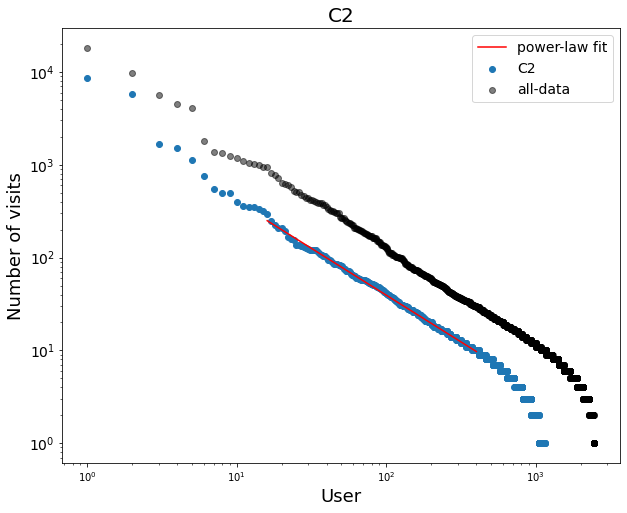



--------------------------


Cluster C3 with 30496 records (26.61151688089566%)

The number of unique users in the cluster C3 is 1431
The mean number of visits per user in this cluster is 21.3109713487072 and the standard deviation 70.28958080424454
The quantil Q1 (25%) is 3.0 visits
The quantil Q2 (50%) is 7.0 visits
The quantil Q3 (75%) is 15.0 visits
The quantil Q4 (90%) is 36.0 visits

Power-law fit with the form f(x)=a·b^x between users 15 and 400
The fit parameters are: a=4126.296379375017 +- 51.81395341548011 and b=-0.9619603121957602 +- 0.0033628242304556202


<ipython-input-7-a03c02dcdd3b>:73: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-7-a03c02dcdd3b>:74: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)


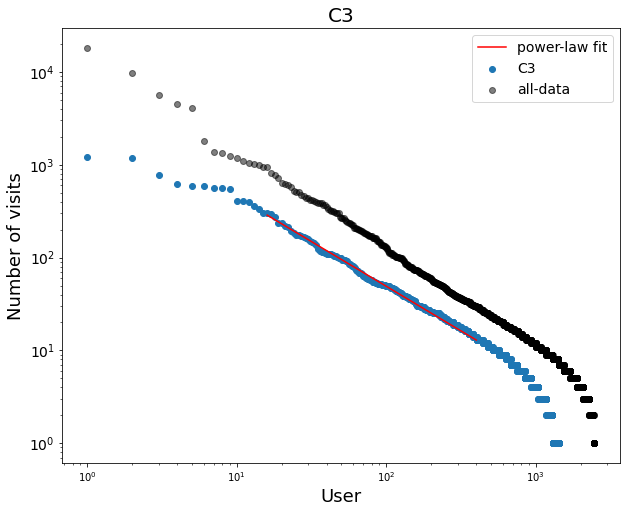



--------------------------




In [7]:
users_c1=[]
users_c2=[]
users_c3=[]
               # List for users_id in each cluster
lenghts=[]    # List for the lenghts of each cluster


for i,j in df.groupby('Segment'):  # Loop over every cluster C1, C2, C3 and C4
    
    print('Cluster {} with {} records ({}%)'.format(i,len(j),len(j)*100/114597))
    print('')

    values = j['id_usuari'].value_counts().keys().tolist()
    counts = j['id_usuari'].value_counts().tolist()
    list_users = list(range(1,len(values)+1))  # Create a list from 1 to length of the users in that cluster (for plot)
    
    lenghts.append(len(j))   # Store the lenght of each cluster and the user ID of each cluster
    if i=='C1':
        users_c1=values
    if i=='C2':
        users_c2=values
    if i=='C3':
        users_c3=values        
        
    # Some statistics for each cluster: number of unique users, mean number of visits per user, standard deviation and quantiles
    mean = sum(counts)/len(counts)
    variance = sum([((x - mean) ** 2) for x in counts]) / len(counts)
    stddev = variance ** 0.5
    q1=np.quantile(counts, .25)
    q2=np.quantile(counts, .50)
    q3=np.quantile(counts, .75)
    q4=np.quantile(counts, .90)

    print('The number of unique users in the cluster {} is {}'.format(i,len(values)))
    print('The mean number of visits per user in this cluster is {} and the standard deviation {}'.format(mean,stddev))
    print('The quantil Q1 (25%) is {} visits'.format(q1))
    print('The quantil Q2 (50%) is {} visits'.format(q2))
    print('The quantil Q3 (75%) is {} visits'.format(q3))
    print('The quantil Q4 (90%) is {} visits'.format(q4))
    print('')
    
    # Plot the number of records of each user (sorted by frequency) for each cluster
    fig, ax1 = plt.subplots(figsize=(10,8)) 
    ax1.scatter(list_users, counts, label=i)    
    ax1.scatter(df_user['code'], df_user['counts'], label='all-data', color='black', alpha=0.5)  # Plot the all-data
    
    if i=='C1':
        popt, pcov = curve_fit(powerlaw, list_users[15:400], counts[15:400], p0=(1,-1))
        times = np.arange(list_users[15], list_users[400], 0.01)
        print('Power-law fit with the form f(x)=a·b^x between users 15 and 400')
        
    if i=='C2':
        popt, pcov = curve_fit(powerlaw, list_users[15:400], counts[15:400], p0=(1,-1))
        times = np.arange(list_users[15], list_users[400], 0.01)
        print('Power-law fit with the form f(x)=a·b^x between users 15 and 400')
        
    if i=='C3':
        popt, pcov = curve_fit(powerlaw, list_users[15:400], counts[15:400], p0=(1,-1))
        times = np.arange(list_users[15], list_users[400], 0.01)      
        print('Power-law fit with the form f(x)=a·b^x between users 15 and 400')
  
        
    model = powerlaw(times, *popt)
    perr = np.sqrt(np.diag(pcov))  #calcul error del parametre
    ax1.plot(times, model, '-',c='red',label='power-law fit')
    
    print('The fit parameters are: a={} +- {} and b={} +- {}'.format(popt[0],perr[0],popt[1],perr[1]))
    
    ax1.set_title(i, fontsize=20)
    ax1.set_xlabel('User',fontsize=18)
    ax1.set_ylabel('Number of visits',fontsize=18)
    ax1.set(xticklabels=[])
    ax1.set_yscale('log',basey=10)
    ax1.set_xscale('log',basex=10)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
    print('')
    print('')
    
    print('--------------------------')
    print('')
    print('')




### 1.2.2. Plot for each cluster (Normalized by cluster size)

Cluster C1 with 44812 records (39.10399050585966%)



<ipython-input-8-97ebe1a419e4>:28: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-8-97ebe1a419e4>:29: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)


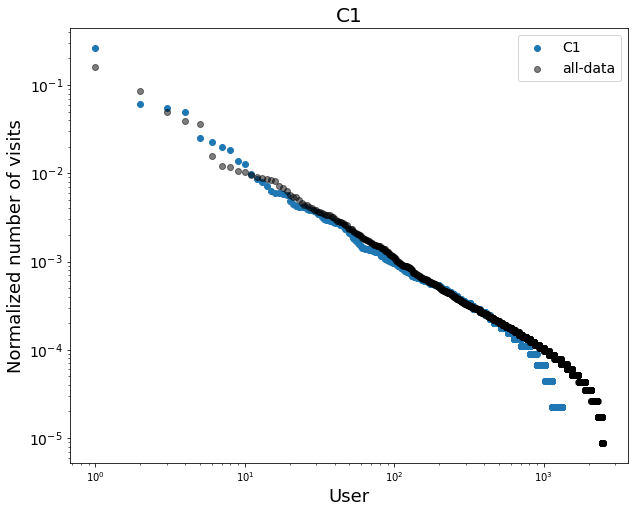



--------------------------


Cluster C2 with 39289 records (34.28449261324467%)



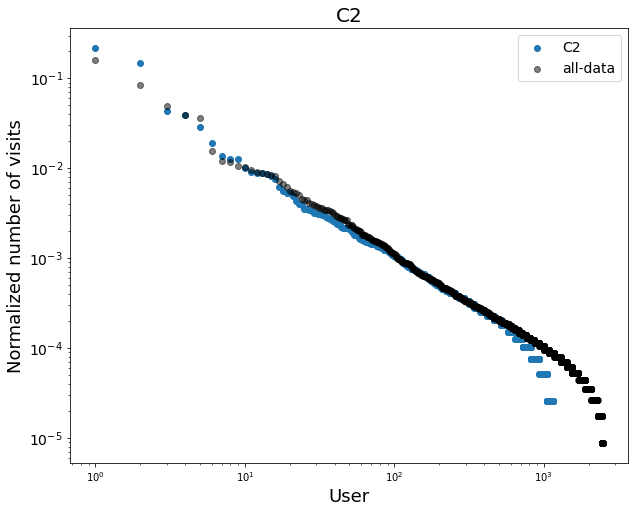



--------------------------


Cluster C3 with 30496 records (26.61151688089566%)



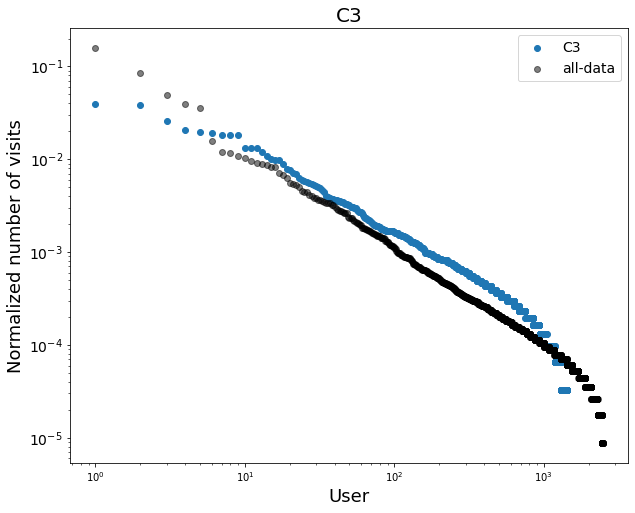



--------------------------




In [8]:
for i,j in df.groupby('Segment'):  # Loop over every cluster C1, C2, C3 and C4
    
    print('Cluster {} with {} records ({}%)'.format(i,len(j),len(j)*100/114597))
    print('')

    values = j['id_usuari'].value_counts().keys().tolist()
    counts = j['id_usuari'].value_counts().tolist()
    list_users = list(range(1,len(values)+1))  # Create a list from 1 to length of the users in that cluster (for plot)
    
    
    # Plot the number of records of each user (sorted by frequency) for each cluster
    fig, ax1 = plt.subplots(figsize=(10,8)) 
    
    # Plot normalized visits (by the cluster size) for each user
    normalized_counts=[]
    for norm in range(len(counts)):
        normalized_counts.append(counts[norm]/len(j))
        
    ax1.scatter(list_users, normalized_counts, label=i)    
    
    # Plot all-data normalized by the number of records (114,597)
    ax1.scatter(df_user['code'], df_user['counts']/len(df), label='all-data', color='black', alpha=0.5) 
    
    ax1.set_title(i, fontsize=20)
    ax1.set_xlabel('User',fontsize=18)
    ax1.set_ylabel('Normalized number of visits',fontsize=18)
    ax1.set(xticklabels=[])
    ax1.set_yscale('log',basey=10)
    ax1.set_xscale('log',basex=10)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
    print('')
    print('')
    
    print('--------------------------')
    print('')
    print('')




### 1.2.3. Single plot including all clusters

<ipython-input-9-f3e15ef02f31>:18: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-9-f3e15ef02f31>:19: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)


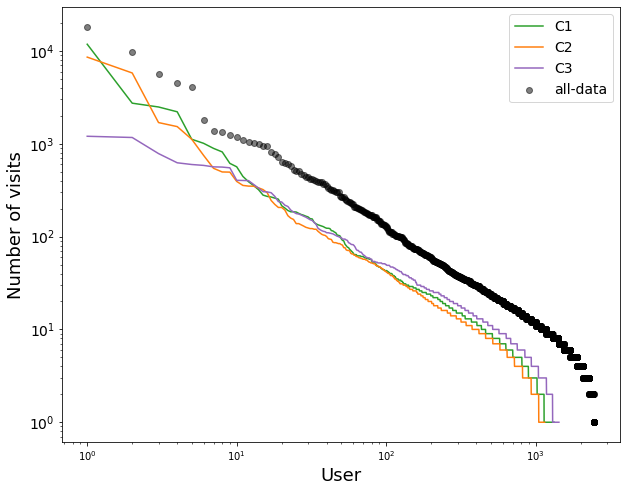

In [9]:
colors=['tab:green','tab:orange','tab:purple','red'] # color of each cluster

fig, ax1 = plt.subplots(figsize=(10,8)) 
ax1.scatter(df_user['code'], df_user['counts'], label='all-data', color='black', alpha=0.5)  # Plot the all-data
c=0
for i,j in df.groupby('Segment'):  # Loop over every cluster C1, C2, C3 and C4

    values = j['id_usuari'].value_counts().keys().tolist()
    counts = j['id_usuari'].value_counts().tolist()
    list_users = list(range(1,len(values)+1))  # Create a list from 1 to length of the users in that cluster (for plot)
    
    ax1.plot(list_users, counts, label=i,color=colors[c])    # Plot frequency of each user in each cluster
    c=c+1

ax1.set_xlabel('User',fontsize=18)
ax1.set_ylabel('Number of visits',fontsize=18)
ax1.set(xticklabels=[])
ax1.set_yscale('log',basey=10)
ax1.set_xscale('log',basex=10)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()





### 1.2.4. Singe plot for all clusters (Normalized by cluster size)

<ipython-input-10-66a65f405723>:24: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-10-66a65f405723>:25: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)


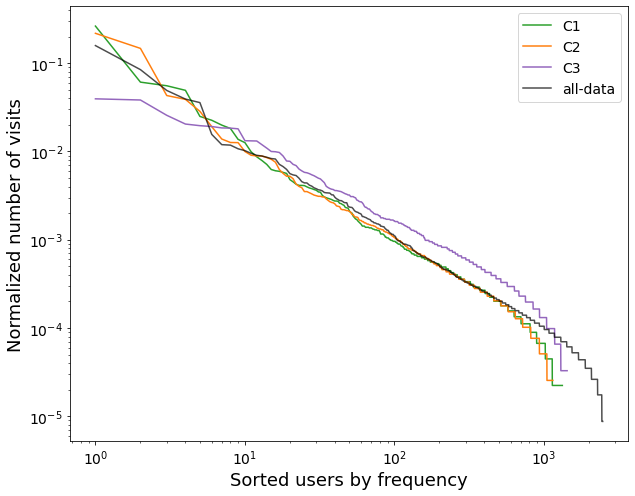

In [10]:
colors=['tab:green','tab:orange','tab:purple','red'] # color of each cluster


fig, ax1 = plt.subplots(figsize=(10,8)) 
c=0
for i,j in df.groupby('Segment'):  # Loop over every cluster C1, C2, C3 and C4

    values = j['id_usuari'].value_counts().keys().tolist()
    counts = j['id_usuari'].value_counts().tolist()
    list_users = list(range(1,len(values)+1))  # Create a list from 1 to length of the users in that cluster (for plot)
    
    normalized_counts=[]
    for norm in range(len(counts)):
        normalized_counts.append(counts[norm]/len(j))
        
    ax1.plot(list_users,normalized_counts, label=i,color=colors[c])    # Plot frequency of each user in each cluster
    c=c+1

ax1.plot(df_user['code'], df_user['counts']/len(df), label='all-data', color='black', alpha=0.7)  # Plot normalized all-data

ax1.set_xlabel('Sorted users by frequency',fontsize=18)
ax1.set_ylabel('Normalized number of visits',fontsize=18)
ax1.set(xticklabels=[])
ax1.set_yscale('log',basey=10)
ax1.set_xscale('log',basex=10)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()




## 1.3. Scatter plot for each cluster pair. Pearson correlation

We scatter the number of visits of each user of each pair of clusters. This gives a measure of the users' correlation betweeen clusters. In other words, if the scattered plot has the shape of a straight line, it means that the same user appears in both clusters with a similar number of visits. Otherwise, it means that it appears many times in one cluster but just a few ones (or zero) in the other cluster.

We also obtain the value of the Pearson correlation between each pair of clusters (comparing users' frequency). The pearson correlation measures how correlated are both variables linearly. So a value near 1 means that the variables are fully correlated (straigth line) and -1 fully anti-correlated. On contrary, a value near 0 means that are not correlated.

##### Pearson correlation

In [11]:
df_users_clusters2=pd.DataFrame()

df_users_clusters2['C1']=df_users_clusters_sorted['C1']
df_users_clusters2['C2']=df_users_clusters_sorted['C2']
df_users_clusters2['C3']=df_users_clusters_sorted['C3']

df_users_clusters2.corr(method='pearson')

,C1,C2,C3
C1,1.000000,0.657007,0.402762
C2,0.657007,1.000000,0.300512
C3,0.402762,0.300512,1.000000


In [12]:
import random

number_visits_c1=df_users_clusters2['C1'].tolist()
number_visits_c2=df_users_clusters2['C2'].tolist()
number_visits_c3=df_users_clusters2['C3'].tolist()

random.shuffle(number_visits_c1)
random.shuffle(number_visits_c2)
random.shuffle(number_visits_c3)

df_users_clusters3=pd.DataFrame()

df_users_clusters3['C1']=number_visits_c1
df_users_clusters3['C2']=number_visits_c2
df_users_clusters3['C3']=number_visits_c3

df_users_clusters3.corr(method='pearson')

,C1,C2,C3
C1,1.000000,-0.001724,-0.000121
C2,-0.001724,1.000000,-0.004698
C3,-0.000121,-0.004698,1.000000


##### Plot pearson correlation between clusters (users' records)

<ipython-input-13-c2d43bec252d>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,'C1', 'C2', 'C3'],fontsize=18)
<ipython-input-13-c2d43bec252d>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0,'C1', 'C2', 'C3'],fontsize=18)


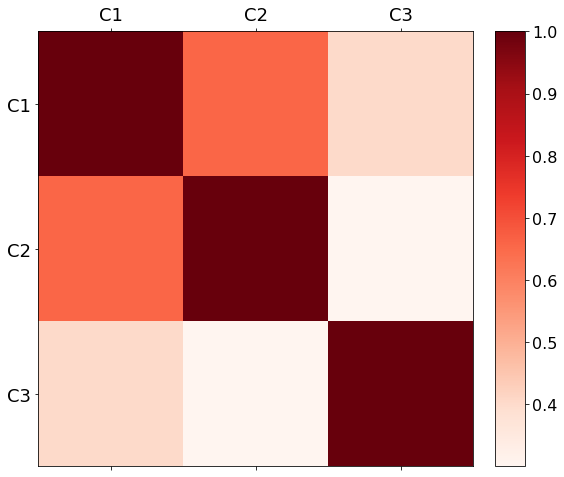

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10,8)) 

im=ax.matshow(df_users_clusters2.corr(method='pearson'),cmap=plt.cm.Reds)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='7%', pad=0.3)

fig.colorbar(im, cax=cax, orientation='vertical')
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=16)

ax.set_xticklabels([0,'C1', 'C2', 'C3'],fontsize=18)
ax.set_yticklabels([0,'C1', 'C2', 'C3'],fontsize=18)

plt.show()

#####  Scatter plot between pairs of clusters

The Pearson correlation between the frequency of users in C1 and C2 is R=0.6570069906175804


<ipython-input-14-c73cd459139f>:12: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('log',basey=10)
<ipython-input-14-c73cd459139f>:13: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log',basex=10)


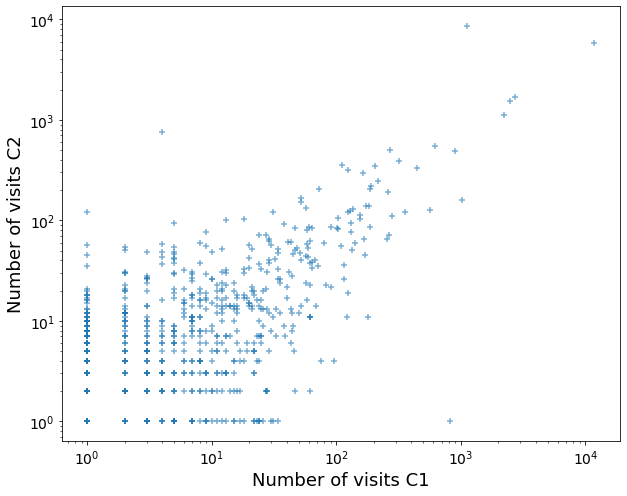



The Pearson correlation between the frequency of users in C1 and C3 is R=0.402762407007325


<ipython-input-14-c73cd459139f>:25: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('log',basey=10)
<ipython-input-14-c73cd459139f>:26: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log',basex=10)


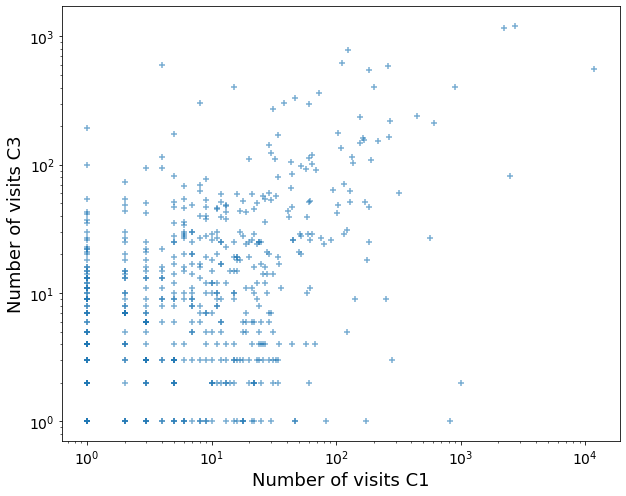



The Pearson correlation between the frequency of users in C2 and C3 is R=0.3005123082258708


<ipython-input-14-c73cd459139f>:39: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('log',basey=10)
<ipython-input-14-c73cd459139f>:40: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log',basex=10)


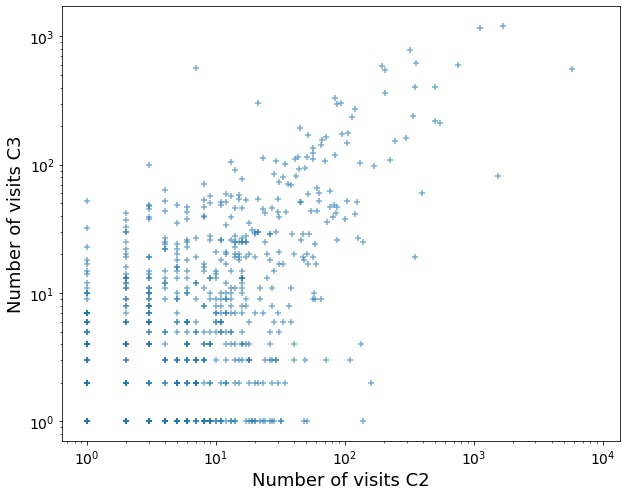

In [14]:
corr_c1_c2=df_users_clusters2.corr(method='pearson')['C1']['C2']
corr_c1_c3=df_users_clusters2.corr(method='pearson')['C1']['C3']
corr_c2_c3=df_users_clusters2.corr(method='pearson')['C2']['C3']

print('The Pearson correlation between the frequency of users in C1 and C2 is R={}'.format(corr_c1_c2))
fig, ax = plt.subplots(figsize=(10,8)) 
ax.scatter(df_users_clusters['C1'],df_users_clusters['C2'],marker='+',alpha=0.6)
ax.set_xlabel('Number of visits C1',fontsize=18)
ax.set_ylabel('Number of visits C2',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_yscale('log',basey=10)
ax.set_xscale('log',basex=10)
plt.show()
print('')
print('')

print('The Pearson correlation between the frequency of users in C1 and C3 is R={}'.format(corr_c1_c3))
fig, ax = plt.subplots(figsize=(10,8)) 
ax.scatter(df_users_clusters['C1'],df_users_clusters['C3'],marker='+',alpha=0.6)
ax.set_xlabel('Number of visits C1',fontsize=18)
ax.set_ylabel('Number of visits C3',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_yscale('log',basey=10)
ax.set_xscale('log',basex=10)
plt.show()
print('')
print('')


print('The Pearson correlation between the frequency of users in C2 and C3 is R={}'.format(corr_c2_c3))
fig, ax = plt.subplots(figsize=(10,8)) 
ax.scatter(df_users_clusters['C2'],df_users_clusters['C3'],marker='+',alpha=0.6)
ax.set_xlabel('Number of visits C2',fontsize=18)
ax.set_ylabel('Number of visits C3',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_yscale('log',basey=10)
ax.set_xscale('log',basex=10)
plt.show()
print('')
print('')



## 1.4. Scatter plot for each cluster pair (Normalized by cluster size)

The Pearson correlation between the frequency of users in C1 and C2 is R=0.6570069906175776


<ipython-input-15-5337de820a9d>:21: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('log',basey=10)
<ipython-input-15-5337de820a9d>:22: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log',basex=10)


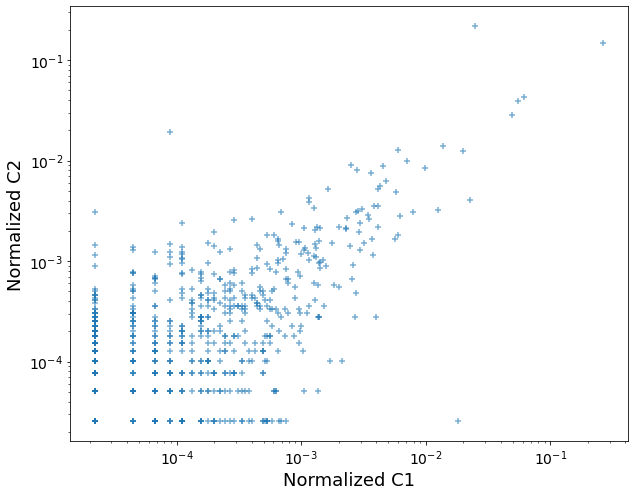



The Pearson correlation between the frequency of users in C1 and C3 is R=0.4027624070073273


<ipython-input-15-5337de820a9d>:34: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('log',basey=10)
<ipython-input-15-5337de820a9d>:35: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log',basex=10)


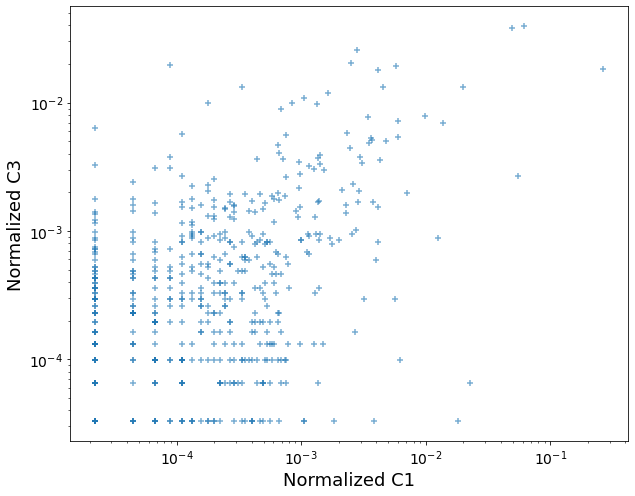



The Pearson correlation between the frequency of users in C2 and C3 is R=0.3005123082258725


<ipython-input-15-5337de820a9d>:48: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('log',basey=10)
<ipython-input-15-5337de820a9d>:49: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log',basex=10)


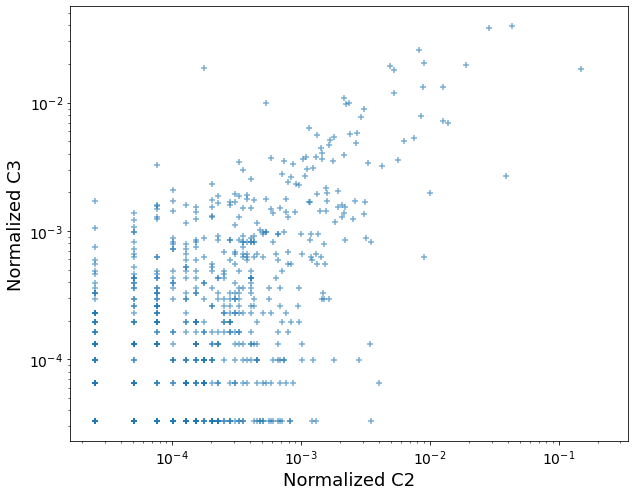

In [15]:
len_c1=sum(df_users_clusters['C1'])
len_c2=sum(df_users_clusters['C2'])
len_c3=sum(df_users_clusters['C3'])

df_users_clusters2_norm=pd.DataFrame()

df_users_clusters2_norm['C1']=df_users_clusters['C1']/len_c1
df_users_clusters2_norm['C2']=df_users_clusters['C2']/len_c2
df_users_clusters2_norm['C3']=df_users_clusters['C3']/len_c3

corr_c1_c2_norm=df_users_clusters2_norm.corr(method='pearson')['C1']['C2']
corr_c1_c3_norm=df_users_clusters2_norm.corr(method='pearson')['C1']['C3']
corr_c2_c3_norm=df_users_clusters2_norm.corr(method='pearson')['C2']['C3']


print('The Pearson correlation between the frequency of users in C1 and C2 is R={}'.format(corr_c1_c2_norm))
fig, ax = plt.subplots(figsize=(10,8)) 
ax.scatter(df_users_clusters['C1']/len_c1,df_users_clusters['C2']/len_c2,marker='+',alpha=0.6)
ax.set_xlabel('Normalized C1',fontsize=18)
ax.set_ylabel('Normalized C2',fontsize=18)
ax.set_yscale('log',basey=10)
ax.set_xscale('log',basex=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
print('')
print('')

print('The Pearson correlation between the frequency of users in C1 and C3 is R={}'.format(corr_c1_c3_norm))
fig, ax = plt.subplots(figsize=(10,8)) 
ax.scatter(df_users_clusters['C1']/len_c1,df_users_clusters['C3']/len_c3,marker='+',alpha=0.6)
ax.set_xlabel('Normalized C1',fontsize=18)
ax.set_ylabel('Normalized C3',fontsize=18)
ax.set_yscale('log',basey=10)
ax.set_xscale('log',basex=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
print('')
print('')


print('The Pearson correlation between the frequency of users in C2 and C3 is R={}'.format(corr_c2_c3_norm))
fig, ax = plt.subplots(figsize=(10,8)) 
ax.scatter(df_users_clusters['C2']/len_c2,df_users_clusters['C3']/len_c3,marker='+',alpha=0.6)
ax.set_xlabel('Normalized C2',fontsize=18)
ax.set_ylabel('Normalized C3',fontsize=18)
ax.set_yscale('log',basey=10)
ax.set_xscale('log',basex=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
print('')
print('')



## 1.5. Plot all-sorted users of each cluster

We plot the SAME user for each cluster and for the all-data in the x-axis. The users are sorted by frequency in the general data-set. Therefore the user 1 is the most frequent in the all data-set but perhaps not in the clusters.

Note that the plot is different than the plots above where the x-axis depends on the users in each cluster, and here the x-axis is general with all the users sorted by frequency in the general data-set.

In this way, we can compare the number of occurences of each user in each cluster. If an user of one cluster is very close to the curve of all-data, it means that almost all the occurences of that user are located in the given cluster.

<ipython-input-15-29763b1eea03>:8: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-15-29763b1eea03>:9: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)


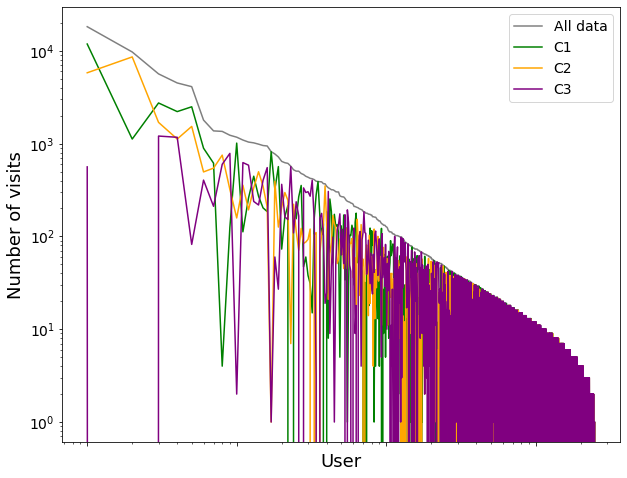

In [15]:
fig, ax1 = plt.subplots(figsize=(10,8)) 

ax1.plot(df_user['code'], df_user['counts'], color='black', label='All data', alpha=0.5)
ax1.plot(df_users_clusters_sorted['code'], df_users_clusters_sorted['C1'], color='green', label='C1')
ax1.plot(df_users_clusters_sorted['code'], df_users_clusters_sorted['C2'], color='orange', label='C2')
ax1.plot(df_users_clusters_sorted['code'], df_users_clusters_sorted['C3'], color='purple', label='C3')

ax1.set_yscale('log',basey=10)
ax1.set_xscale('log',basex=10)

ax1.set_xlabel('User',fontsize=18)
ax1.set_ylabel('Number of visits',fontsize=18)

ax1.set(xticklabels=[])
plt.yticks(fontsize=14)


#add legend
plt.legend(fontsize=14)

plt.show()

## 1.6. Common users in clusters

##### A. Common users in each cluster pair (C1-C2, C1-C3, C2-C3)

In [17]:
def common(lst1, lst2): 
    return list(set(lst1) & set(lst2))

print('Cluster C1 has {} records ({}%) and {} unique users'.format(lenghts[0], lenghts[0]*100/114597,len(users_c1)))
print('Cluster C2 has {} records ({}%) and {} unique users'.format(lenghts[1], lenghts[1]*100/114597,len(users_c2)))
print('The cluster C1 and the cluster C2 have {} users in common'.format(len(common(users_c1,users_c2))))
print('{}% of the users in C1 are also in C2 ({}% of the users in C2)'
      .format(len(common(users_c1,users_c2))*100/len(users_c1),len(common(users_c1,users_c2))*100/len(users_c2)))
print('')
print('')

print('Cluster C1 has {} records ({}%) and {} unique users'.format(lenghts[0], lenghts[0]*100/114597,len(users_c1)))
print('Cluster C3 has {} records ({}%) and {} unique users'.format(lenghts[2], lenghts[2]*100/114597,len(users_c3)))
print('The cluster C1 and the cluster C3 have {} users in common'.format(len(common(users_c1,users_c3))))
print('{}% of the users in C1 are also in C3 ({}% of the users in C3)'
      .format(len(common(users_c1,users_c3))*100/len(users_c1),len(common(users_c1,users_c3))*100/len(users_c3)))
print('')
print('')


print('Cluster C2 has {} records ({}%) and {} unique users'.format(lenghts[1], lenghts[1]*100/114597,len(users_c2)))
print('Cluster C3 has {} records ({}%) and {} unique users'.format(lenghts[2], lenghts[2]*100/114597,len(users_c3)))
print('The cluster C2 and the cluster C3 have {} users in common'.format(len(common(users_c2,users_c3))))
print('{}% of the users in C2 are also in C3 ({}% of the users in C3)'
      .format(len(common(users_c2,users_c3))*100/len(users_c2),len(common(users_c2,users_c3))*100/len(users_c3)))
print('')
print('')




Cluster C1 has 44812 records (39.10399050585966%) and 1329 unique users
Cluster C2 has 39289 records (34.28449261324467%) and 1148 unique users
The cluster C1 and the cluster C2 have 668 users in common
50.263355906696766% of the users in C1 are also in C2 (58.18815331010453% of the users in C2)


Cluster C1 has 44812 records (39.10399050585966%) and 1329 unique users
Cluster C3 has 30496 records (26.61151688089566%) and 1431 unique users
The cluster C1 and the cluster C3 have 522 users in common
39.27765237020316% of the users in C1 are also in C3 (36.477987421383645% of the users in C3)


Cluster C2 has 39289 records (34.28449261324467%) and 1148 unique users
Cluster C3 has 30496 records (26.61151688089566%) and 1431 unique users
The cluster C2 and the cluster C3 have 621 users in common
54.09407665505226% of the users in C2 are also in C3 (43.39622641509434% of the users in C3)




##### B. Common users in all 3 clusters


In [33]:
def common2(lst1, lst2, lst3): 
    return list(set(lst1) & set(lst2) & set(lst3))

common_users=common2(users_c1,users_c2,users_c3)
counts_common_users=[]
for user in common_users:
    df_common_users = df.apply(lambda x : True if x['id_usuari'] == user else False, axis = 1)
  
    # Count number of True in the series
    num_rows = len(df_common_users[df_common_users == True].index)
    counts_common_users.append(num_rows)
    
print('The clusters C1, C2 and C3 have {} users in common'.format(len(common_users)))
print('{}% of C1, {}% of C2 and {}% of C3'.format(len(common_users)*100/len(users_c1), 
                                                             len(common_users)*100/len(users_c2), 
                                                             len(common_users)*100/len(users_c3)))
print('The common user in the four clusters with more visits has {} records'.format(max(counts_common_users)))
print('The common user in the four clusters with less visits has {} records'.format(min(counts_common_users)))
print('The average number of visits of the common users is {} records and the standard deviation is {}'
     .format(np.mean(counts_common_users), np.std(counts_common_users)))


q1_common_users=np.quantile(counts_common_users, .25)  # Quantiles
q2_common_users=np.quantile(counts_common_users, .50)
q3_common_users=np.quantile(counts_common_users, .75)
q4_common_users=np.quantile(counts_common_users, .95)

print('Q1. The 25% of the users have {} or less visits.'.format(q1_common_users))
print('Q2. The 50% of the users have {} or less visits.'.format(q2_common_users))
print('Q3. The 75% of the users have {} or less visits.'.format(q3_common_users))
print('Just the 5% of the users have more than {} visits'.format(q4_common_users))

The clusters C1, C2 and C3 have 378 users in common
28.442437923250566% of C1, 32.926829268292686% of C2 and 26.41509433962264% of C3
The common user in the four clusters with more visits has 18170 records
The common user in the four clusters with less visits has 3 records
The average number of visits of the common users is 206.3095238095238 records and the standard deviation is 1038.0796229894463
Q1. The 25% of the users have 22.0 or less visits.
Q2. The 50% of the users have 46.5 or less visits.
Q3. The 75% of the users have 111.0 or less visits.
Just the 5% of the users have more than 625.1499999999995 visits


##### C. Plot common users in all clusters and all-data users

Plot the number of visits (of the whole data-set) of each user who is found in the 4 clusters simultaneously. The Power-law fit is included.

We also plot all users' visits to compare.

Note that the users in the x-axis are not the same (they are sorted by frequency)

Power-law fit with the form f(x)=a·b^x between user 15 and 150
The fit parameters are: a=16739.46054579929 +- 336.144062826344 and b=-1.097082680964065 +- 0.005799765634856175


<ipython-input-44-affa276c51c5>:23: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-44-affa276c51c5>:24: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)


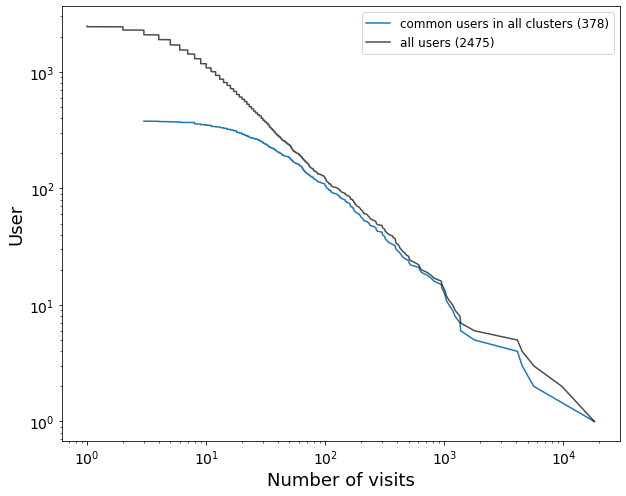

In [44]:
list_common_users = list(range(1,len(common_users)+1))  # Create a list from 1 to length of the users in that cluster
counts_common_users.sort(reverse=True)

fig, ax1 = plt.subplots(figsize=(10,8)) 

ax1.plot(counts_common_users,list_common_users, label='common users in all clusters (378)')    
ax1.plot( df_user['counts'],df_user['code'], label='all users (2475)', color='black', alpha=0.7) 

# Power-law fit
popt, pcov = curve_fit(powerlaw, list_common_users[15:150], counts_common_users[15:150], p0=(1,-1))
times = np.arange(list_common_users[15], list_common_users[150], 0.01)
model = powerlaw(times, *popt)
perr = np.sqrt(np.diag(pcov))  #calcul error del parametre
#ax1.plot(times, model, '-',c='red',label='power-law fit')

print('Power-law fit with the form f(x)=a·b^x between user 15 and 150')
print('The fit parameters are: a={} +- {} and b={} +- {}'.format(popt[0],perr[0],popt[1],perr[1]))


ax1.set_ylabel('User',fontsize=18)
ax1.set_xlabel('Number of visits',fontsize=18)
ax1.set(xticklabels=[])
ax1.set_yscale('log',basey=10)
ax1.set_xscale('log',basex=10)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=12)


plt.show()
    



#####  Plot all-users and color in red the common users in the 3 clusters

<ipython-input-27-397532a168a4>:9: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-27-397532a168a4>:10: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)


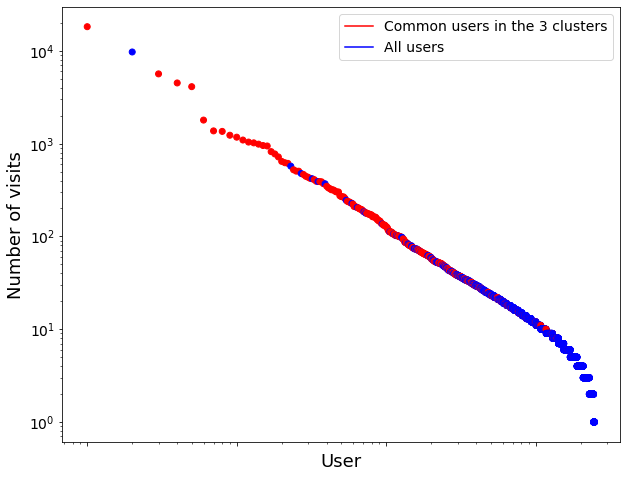

In [27]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D   # To set manually the legend

fig, ax1 = plt.subplots(figsize=(10,8)) 
series=df_user['values'].isin(common_users)
colors=np.where(series==True, 'red', 'blue')
ax1.scatter(df_user['code'], df_user['counts'], color=colors)

ax1.set_yscale('log',basey=10)
ax1.set_xscale('log',basex=10)

ax1.set_xlabel('User',fontsize=18)
ax1.set_ylabel('Number of visits',fontsize=18)

ax1.set(xticklabels=[])
plt.yticks(fontsize=14)

# We set manually the legend
handles, labels = plt.gca().get_legend_handles_labels()
#define patches and lines to add to legend
line1 = Line2D([0], [0], label='Common users in the 3 clusters', color='red')
line2 = Line2D([0], [0], label='All users', color='blue')

#add handles
handles.extend([line1, line2])

#add legend
plt.legend(handles=handles, fontsize=14)

plt.show()

#  2. Clustering Users. DBSCAN Algorithm

We apply again a clustering algorithm with the new Data-set, using the number of visits of each user in each cluster and weekday. In this way, we clusterize unique users and not visits/consumption units. We have 2475 rows (each unique user) and 11 columns (C1,C2,C3,C4,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday).

We use the well-known DBSCAN algorithm, which works with continuous (numerical) data (instead of K-Prototypes for mixed data) and is based in density regions. We could also use the K-Means algorithm however, after several tests, we get better results with DBSCAN.

In [16]:
df3=df_users_clusters.copy()        # Make a copy of the data-set with only the columns to clusterize (2475x11)

del df3['max count']
del df3['max label']
del df3['min count']
del df3['min label']
del df3['usuari_id']
#del df3['C4']
del df3['total_counts']


df3

,C1,C2,C3,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,11818,5791,561,2909,4260,4740,3401,2860,0,0
1,3,0,0,0,0,0,0,3,0,0
2,2491,1531,82,675,725,1149,1013,539,0,3
3,184,138,25,78,29,47,134,41,18,0
4,267,71,166,98,125,115,75,53,10,28
...,...,...,...,...,...,...,...,...,...,...
2470,0,0,6,6,0,0,0,0,0,0
2471,0,0,10,10,0,0,0,0,0,0
2472,0,0,2,2,0,0,0,0,0,0
2473,0,0,5,5,0,0,0,0,0,0


## 2.1. Pre-processing. Standarization

We standarize the columns in order to have zero mean and unit variance (then there is no scaling problems in the algorithm). However, we can check that without this pre-processing step the result is qualitatively the same.

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df3)  # Use the StandardScaler with returns the columns with zero mean and unit variance
        

## 2.2. DBSCAN Algorithm

https://www.reneshbedre.com/blog/dbscan-python.html

Density Based Spatial Clustering of Applications with Noise (DBSCAN) is a density-based unsupervised clustering algorithm. In DBSCAN, clusters are formed from dense regions and separated by regions of no or low densities. DBSCAN computes nearest neighbor graphs and creates arbitrary-shaped clusters in datasets (which may contain noise or outliers) as opposed to k-means clustering, which typically generates spherical-shaped clusters.

Unlike k-means clustering, DBSCAN does not require specifying the number of clusters initially. However, DBSCAN requires two parameters viz. the radius of neighborhoods for a given data point p (eps or ε) and the minimum number of data points in a given ε-neighborhood to form clusters (minPts).


DBSCAN requires ε and minPts parameters for clustering. The minPts parameter is easy to set. The minPts should be 4 for two-dimensional dataset. For multidimensional dataset, minPts should be 2 * number of dimensions. For example, if your dataset has 6 features, set minPts = 12.

Another question is what optimal value should be used for the ε parameter. The ε parameter is difficult to set and depends on the distance function. Sometimes, domain expertise is also required to set a ε parameter. The ε should be as small as possible. To determine the optimal ε parameter, it is useful to compute the k-nearest neighbor (kNN) distances (average distance of every data point to its k-nearest neighbors) of an input dataset using the k-nearest neighbor method (unsupervised nearest neighbors learning).

### 2.2.1. Determine minPts and ε

Since we have 11 dimensions. The minPts is 11·2 = 22

For the ε, we compute the K-nearest neighbor (KNN) distances. NearestNeighbors function requires n_neighbors (number of neighbors) parameter, which can be same as the minPts value.

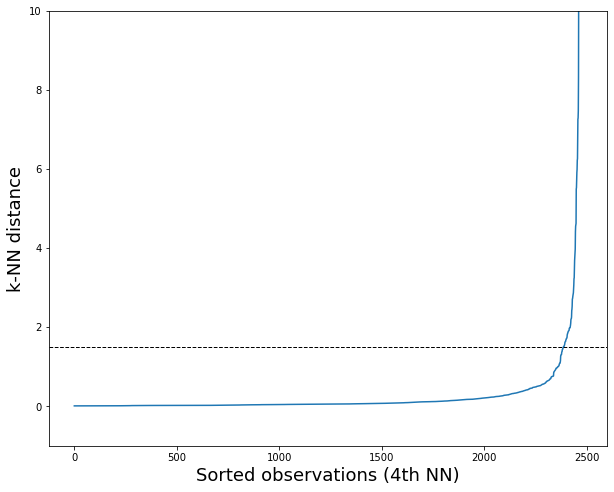

In [18]:
from sklearn.neighbors import NearestNeighbors

# n_neighbors = 22 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors=22).fit(scaled_features)

# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(scaled_features)

# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)


# Now, get the sorted kth column (distances with kth neighbors) and plot the kNN distance plot
k_dist = sort_neigh_dist[:, 21]

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(k_dist)
plt.axhline(y=1.5, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance", fontsize=18)
plt.xlabel("Sorted observations (4th NN)",fontsize=18)
plt.ylim(-1,10)
plt.show()

### 2.2.2. DBSCAN Algorithm with k=2

In [19]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=1.5, min_samples=22).fit(scaled_features)

In [20]:
df_dbscan=df3.copy()
df_dbscan['Clusters']=clusters.labels_

In [21]:
df_dbscan['Segment'] = df_dbscan['Clusters'].map({-1:'C2 DBSCAN', 0:'C1 DBSCAN'})
df_dbscan['Segment'] = df_dbscan['Segment'].astype('category')
df_dbscan['user_id']=df_users_clusters['usuari_id']
df_dbscan['total_counts'] = df_dbscan[['C1', 'C2', 'C3']].astype(float).sum(1)
df_dbscan

,C1,C2,C3,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Clusters,Segment,user_id,total_counts
0,11818,5791,561,2909,4260,4740,3401,2860,0,0,-1,C2 DBSCAN,863,18170.0
1,3,0,0,0,0,0,0,3,0,0,0,C1 DBSCAN,1444,3.0
2,2491,1531,82,675,725,1149,1013,539,0,3,-1,C2 DBSCAN,1504,4104.0
3,184,138,25,78,29,47,134,41,18,0,0,C1 DBSCAN,3064,347.0
4,267,71,166,98,125,115,75,53,10,28,-1,C2 DBSCAN,3422,504.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,0,0,6,6,0,0,0,0,0,0,0,C1 DBSCAN,37127,6.0
2471,0,0,10,10,0,0,0,0,0,0,0,C1 DBSCAN,37130,10.0
2472,0,0,2,2,0,0,0,0,0,0,0,C1 DBSCAN,37152,2.0
2473,0,0,5,5,0,0,0,0,0,0,0,C1 DBSCAN,37155,5.0


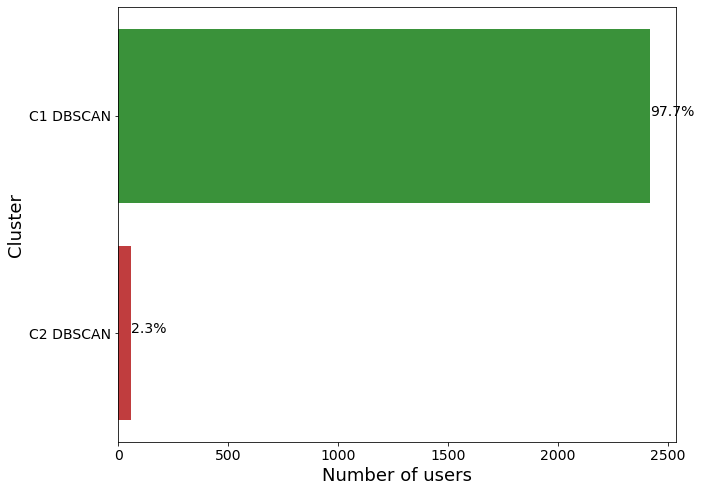

C1 DBSCAN    2418
C2 DBSCAN      57
Name: Segment, dtype: int64

In [22]:
fig, ax = plt.subplots(figsize=(10,8))
colors=['tab:green','tab:red','tab:purple','tab:orange' ]
ax = sns.countplot(y=df_dbscan['Segment'], data=df_dbscan['Segment'],order = df_dbscan['Segment'].value_counts().index, palette=colors)
plt.xlabel('Number of users',fontsize=18)
plt.ylabel('Cluster',fontsize=18)


total = sum(df_dbscan['Segment'].value_counts())
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    value=p.get_width()
    x = p.get_x() + p.get_width() + 0.1
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y),fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

df_dbscan['Segment'].value_counts()

## 2.3. Clustering interpretation (DBSCAN)

We analyse the results of the DBSCAN Algorithm which finds k=2 clusters. One containing almost all the users (2418, 98% and the other want only 57 users, 2%). 

We create 2 new data-frames, one with the users at C1 and one with the users at C2.  We also add a new column with the total visits/consumption units of each user.

##### Cluster  C1 (98%, 2418 users)

In [23]:
df_c1= df_dbscan.loc[df_dbscan['Segment'] == 'C1 DBSCAN']   # Only those users belonging to C1
df_c1['total_counts'] = df_c1[['C1', 'C2', 'C3']].astype(float).sum(1)   # Add new column with the total visits
print('The number of consumption units/visits in C1 DBSCAN is {} ({} % of the total)'.format(sum(df_c1['total_counts']), 
                                                                                     sum(df_c1['total_counts'])*100/114597))

The number of consumption units/visits in C1 DBSCAN is 44257.0 (38.6196846339782 % of the total)


<ipython-input-23-730c5cb1bb5c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c1['total_counts'] = df_c1[['C1', 'C2', 'C3']].astype(float).sum(1)   # Add new column with the total visits


##### Cluster C2 (2%, 57 users)

In [24]:
df_c2= df_dbscan.loc[df_dbscan['Segment'] == 'C2 DBSCAN']   # Only those users belonging to C1
df_c2['total_counts'] = df_c2[['C1', 'C2', 'C3']].astype(float).sum(1)   # Add new column with the total visits
print('The number of consumption units/visits in C2 DBSCAN is {} ({} % of the total)'.format(sum(df_c2['total_counts']), 
                                                                                     sum(df_c2['total_counts'])*100/114597))

The number of consumption units/visits in C2 DBSCAN is 70340.0 (61.3803153660218 % of the total)


<ipython-input-24-1ba0d6cb5a64>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c2['total_counts'] = df_c2[['C1', 'C2', 'C3']].astype(float).sum(1)   # Add new column with the total visits


In [30]:
#df_c1.describe()

In [47]:
#df_c2.describe()

#### Cluster C1 DBSCAN. 2418 users (98%). 44,257 consumption units/visits (39% of the total)

- < counts per user > = 18  
- $\sigma=32$
- q1(25%)=5
- q2(50%)=9
- q3(75%)=18
- min=1
- max=393



#### Cluster C2 DBSCAN. 57 users (2%). 70,340 consumption units/visits  (61% of the total)

- < counts per user > = 1234  
- $\sigma=2768$
- q1(25%)=267
- q2(50%)=444
- q3(75%)=953
- min=86
- max=18170


### 2.3.1. Plot number of visits per user 

We plot the number of visits (counts) of each user (sorted by frenquency) and color each user in red if belongs to C1 and in green if belongs to C2 of the DBSCAN


In [61]:
sorted_df_dbscan = df_dbscan.sort_values(by='total_counts',ascending=False)  # Sort by total counts (frequency). New Data-Frame
sorted_df_dbscan["color"] = np.where(sorted_df_dbscan["Segment"]=="C1 DBSCAN", "green", "red") # Add color column (red C1, green C2)
sorted_df_dbscan

,C1,C2,C3,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Clusters,Segment,user_id,total_counts,color
0,11818,5791,561,2909,4260,4740,3401,2860,0,0,-1,C2 DBSCAN,863,18170.0,red
458,1119,8583,0,3352,3258,1077,394,1621,0,0,-1,C2 DBSCAN,20326,9702.0,red
5,2738,1692,1205,1360,564,1154,1703,853,1,0,-1,C2 DBSCAN,3522,5635.0,red
541,2211,1120,1169,668,809,622,823,489,601,488,-1,C2 DBSCAN,21804,4500.0,red
2,2491,1531,82,675,725,1149,1013,539,0,3,-1,C2 DBSCAN,1504,4104.0,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,0,0,1,0,0,0,1,0,0,0,0,C1 DBSCAN,34099,1.0,green
2413,1,0,0,0,0,1,0,0,0,0,0,C1 DBSCAN,36979,1.0,green
1885,0,1,0,0,1,0,0,0,0,0,0,C1 DBSCAN,35358,1.0,green
675,0,0,1,0,0,0,0,0,0,1,0,C1 DBSCAN,25261,1.0,green


##### bar-plot users

<ipython-input-49-0e222948d2db>:13: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log',basex=10)
<ipython-input-49-0e222948d2db>:14: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('log',basey=10)


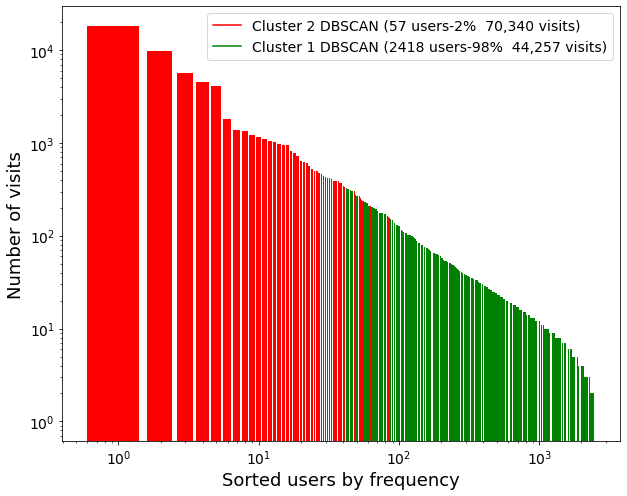

In [49]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D   # To set manually the legend

counts_users=sorted_df_dbscan['total_counts'].tolist() # Counts (number of visits) of each user
colors=sorted_df_dbscan['color'].tolist()  # Colors to list (red for C1 and green for C2)
users= list(range(1,len(counts_users)+1))  # Create a list from 1 to length of the users 

# Bar-Plot of users vs number of visits, sorted by frequency. Users belonging to C1 are colored in red and C2 in green.
fig, ax = plt.subplots(figsize=(10,8))
for i in range(len(users)):
    ax.bar(users[i],counts_users[i], color=colors[i])

ax.set_xscale('log',basex=10)
ax.set_yscale('log',basey=10)
ax.set_xlabel('Sorted users by frequency',fontsize=18)
ax.set_ylabel('Number of visits',fontsize=18)


# We set manually the legend
handles, labels = plt.gca().get_legend_handles_labels()
#define patches and lines to add to legend
line1 = Line2D([0], [0], label='Cluster 2 DBSCAN (57 users-2%  70,340 visits)', color='red')
line2 = Line2D([0], [0], label='Cluster 1 DBSCAN (2418 users-98%  44,257 visits)', color='green')

#add handles
handles.extend([line1, line2])

#add legend
plt.legend(handles=handles, fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()



##### scatter-plot users

<ipython-input-50-1cada7a20491>:13: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log',basex=10)


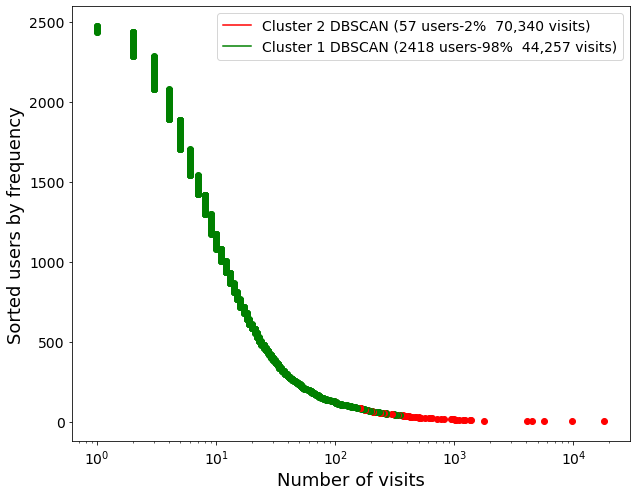

In [50]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D   # To set manually the legend

counts_users=sorted_df_dbscan['total_counts'].tolist() # Counts (number of visits) of each user
colors=sorted_df_dbscan['color'].tolist()  # Colors to list (red for C1 and green for C2)
users= list(range(1,len(counts_users)+1))  # Create a list from 1 to length of the users 

# Bar-Plot of users vs number of visits, sorted by frequency. Users belonging to C1 are colored in red and C2 in green.
fig, ax = plt.subplots(figsize=(10,8))
for i in range(len(users)):
    ax.scatter(counts_users[i],users[i], color=colors[i])

ax.set_xscale('log',basex=10)
#ax.set_yscale('log',basey=10)
ax.set_ylabel('Sorted users by frequency',fontsize=18)
ax.set_xlabel('Number of visits',fontsize=18)


# We set manually the legend
handles, labels = plt.gca().get_legend_handles_labels()
#define patches and lines to add to legend
line1 = Line2D([0], [0], label='Cluster 2 DBSCAN (57 users-2%  70,340 visits)', color='red')
line2 = Line2D([0], [0], label='Cluster 1 DBSCAN (2418 users-98%  44,257 visits)', color='green')

#add handles
handles.extend([line1, line2])

#add legend
plt.legend(handles=handles, fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()



### 2.3.2. Users cluster versus consumption cluster 

We plot, for each of the two users clusters, the number of records/visits for each of the 3 original clusters of visits

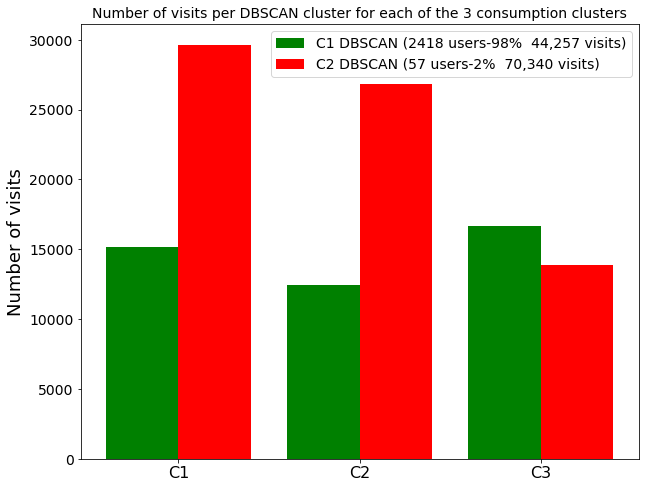

In [105]:
fig, ax = plt.subplots(figsize=(10,8))

Clusters= ['C1','C2','C3']
c1_counts=[sum(df_c1['C1']), sum(df_c1['C2']), sum(df_c1['C3'])]
c2_counts=[sum(df_c2['C1']), sum(df_c2['C2']), sum(df_c2['C3'])]

X_axis = np.arange(len(Clusters))
  
plt.bar(X_axis - 0.2, c1_counts, 0.4, label = 'C1 DBSCAN (2418 users-98%  44,257 visits)', color='green')
plt.bar(X_axis + 0.2, c2_counts, 0.4, label = 'C2 DBSCAN (57 users-2%  70,340 visits)', color='red')
  
plt.xticks(X_axis, Clusters, fontsize=16)
#plt.xlabel("Groups")
plt.ylabel("Number of visits", fontsize=18)
plt.title("Number of visits per DBSCAN cluster for each of the 3 consumption clusters",fontsize=14)

plt.yticks(fontsize=14)

ax.legend(fontsize=14)
plt.show()

##### Normalized  Bar-plot by cluster size

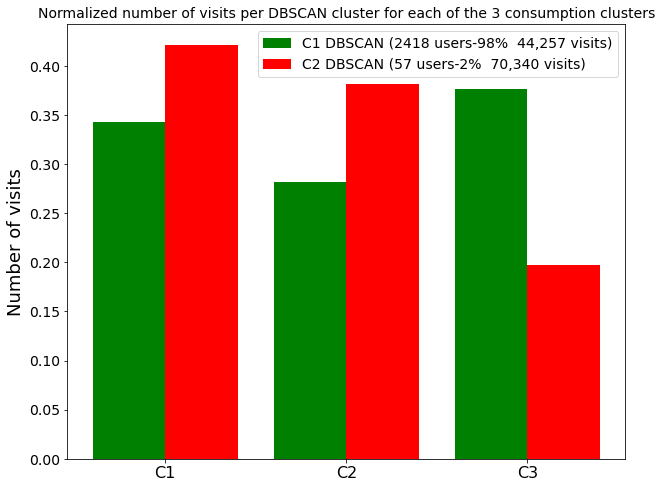

In [65]:
fig, ax = plt.subplots(figsize=(10,8))

Clusters= ['C1','C2','C3']
c1_counts=[sum(df_c1['C1'])/sum(df_c1['total_counts']), sum(df_c1['C2'])/sum(df_c1['total_counts']), 
           sum(df_c1['C3'])/sum(df_c1['total_counts'])]

c2_counts=[sum(df_c2['C1'])/sum(df_c2['total_counts']), sum(df_c2['C2'])/sum(df_c2['total_counts']),
           sum(df_c2['C3'])/sum(df_c2['total_counts'])]

X_axis = np.arange(len(Clusters))
  
plt.bar(X_axis - 0.2, c1_counts, 0.4, label = 'C1 DBSCAN (2418 users-98%  44,257 visits)', color='green')
plt.bar(X_axis + 0.2, c2_counts, 0.4, label = 'C2 DBSCAN (57 users-2%  70,340 visits)', color='red')
  
plt.xticks(X_axis, Clusters, fontsize=16)
#plt.xlabel("Groups")
plt.title("Normalized number of visits per DBSCAN cluster for each of the 3 consumption clusters",fontsize=14)
plt.ylabel("Number of visits", fontsize=18)
plt.yticks(fontsize=14)
ax.legend(fontsize=14)
plt.show()

In [67]:
print(c2_counts)

[0.42150980949673017, 0.38148990617003126, 0.19700028433323855]


### 2.3.3. Users cluster versus weekday

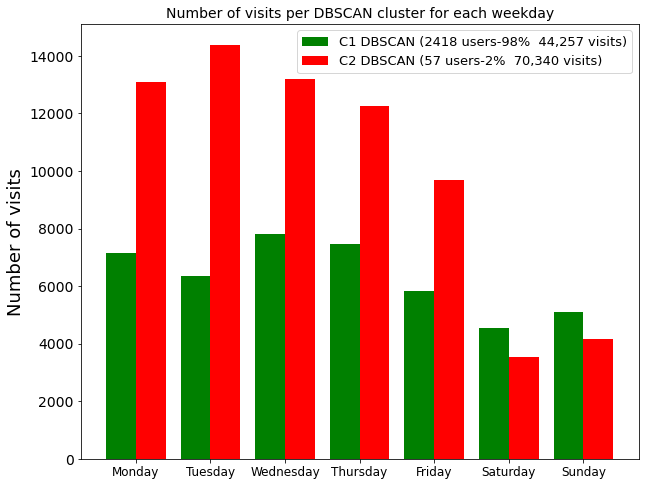

In [108]:
fig, ax = plt.subplots(figsize=(10,8))

Clusters= ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
c1_counts=[sum(df_c1['Monday']), sum(df_c1['Tuesday']), sum(df_c1['Wednesday']), sum(df_c1['Thursday']), 
           sum(df_c1['Friday']),  sum(df_c1['Saturday']),  sum(df_c1['Sunday'])]
c2_counts=[sum(df_c2['Monday']), sum(df_c2['Tuesday']), sum(df_c2['Wednesday']), sum(df_c2['Thursday']),
           sum(df_c2['Friday']),  sum(df_c2['Saturday']),  sum(df_c2['Sunday'])]

X_axis = np.arange(len(Clusters))
  
plt.bar(X_axis - 0.2, c1_counts, 0.4, label = 'C1 DBSCAN (2418 users-98%  44,257 visits)', color='green')
plt.bar(X_axis + 0.2, c2_counts, 0.4, label = 'C2 DBSCAN (57 users-2%  70,340 visits)', color='red')
  
plt.xticks(X_axis, Clusters, fontsize=12)
#plt.xlabel("Groups")
plt.title("Number of visits per DBSCAN cluster for each weekday",fontsize=14)
plt.ylabel("Number of visits", fontsize=18)

plt.yticks(fontsize=14)

ax.legend(fontsize=13)
plt.show()

##### Normalized Bar-plot by cluster size

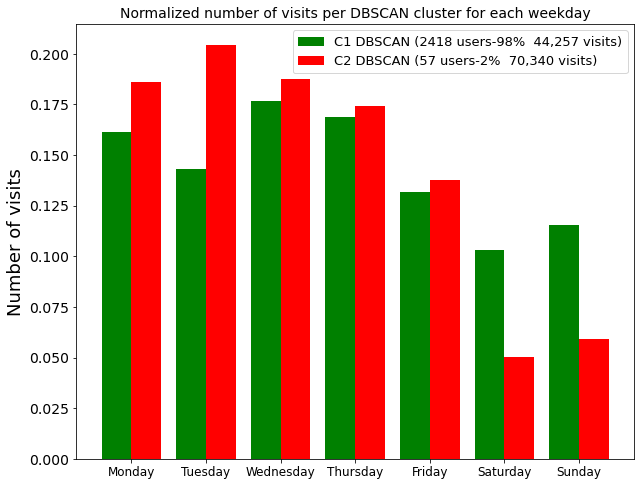

In [60]:
fig, ax = plt.subplots(figsize=(10,8))

Clusters= ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
c1_counts=[sum(df_c1['Monday'])/sum(df_c1['total_counts']), sum(df_c1['Tuesday'])/sum(df_c1['total_counts']), 
           sum(df_c1['Wednesday'])/sum(df_c1['total_counts']), sum(df_c1['Thursday'])/sum(df_c1['total_counts']), 
           sum(df_c1['Friday'])/sum(df_c1['total_counts']),  sum(df_c1['Saturday'])/sum(df_c1['total_counts']),  
           sum(df_c1['Sunday'])/sum(df_c1['total_counts'])]
c2_counts=[sum(df_c2['Monday'])/sum(df_c2['total_counts']), sum(df_c2['Tuesday'])/sum(df_c2['total_counts']), 
           sum(df_c2['Wednesday'])/sum(df_c2['total_counts']), sum(df_c2['Thursday'])/sum(df_c2['total_counts']),
           sum(df_c2['Friday'])/sum(df_c2['total_counts']),  sum(df_c2['Saturday'])/sum(df_c2['total_counts']), 
           sum(df_c2['Sunday'])/sum(df_c2['total_counts'])]

X_axis = np.arange(len(Clusters))
  
plt.bar(X_axis - 0.2, c1_counts, 0.4, label = 'C1 DBSCAN (2418 users-98%  44,257 visits)', color='green')
plt.bar(X_axis + 0.2, c2_counts, 0.4, label = 'C2 DBSCAN (57 users-2%  70,340 visits)', color='red')
  
plt.xticks(X_axis, Clusters, fontsize=12)
#plt.xlabel("Groups")
plt.title("Normalized number of visits per DBSCAN cluster for each weekday",fontsize=14)
plt.ylabel("Number of visits", fontsize=18)

plt.yticks(fontsize=14)

ax.legend(fontsize=13)
plt.show()

# 3. DISPARITY MEASURE

We measure the disparity between the number of visits for user in each cluster.

We first propose the following method:

    1. For each user, we obtain the largest number of visits of the 3 clusters and the smallest. 
    2. Then, we measure the difference between both quantites, we'll have 2475 values (one for each user).
    3. Plot the PDF of the disparity
    4. Repeat the process above normalizing the number of counts by the cluster size

In [71]:
# Difference between the largest number of visits and the smallest, for each user

df_users_clusters['diff']=df_users_clusters['max count']-df_users_clusters['min count']

##### Pdf of the disparity measure 

<ipython-input-72-8e3c6ced353f>:7: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('log',basey=10)


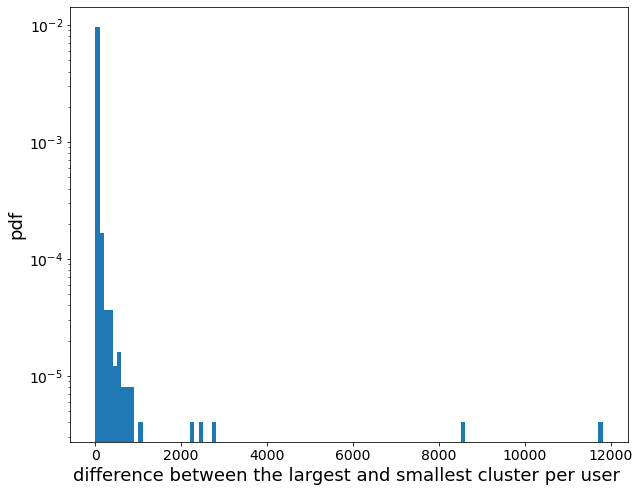

In [72]:
fig, ax = plt.subplots(figsize=(10,8))

diff=df_users_clusters['diff'].tolist()
bins=int((max(diff)-min(diff))/100) # using bins of 200 visits

df_users_clusters['diff'].plot.hist(bins=bins,density=True)
ax.set_yscale('log',basey=10)
#ax.set_xscale('log',basex=10)

plt.xlabel("difference between the largest and smallest cluster per user ", fontsize=18)
plt.ylabel("pdf", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

##### Normalized pdf by cluster size

<ipython-input-73-bf2282604795>:26: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('log',basey=10)


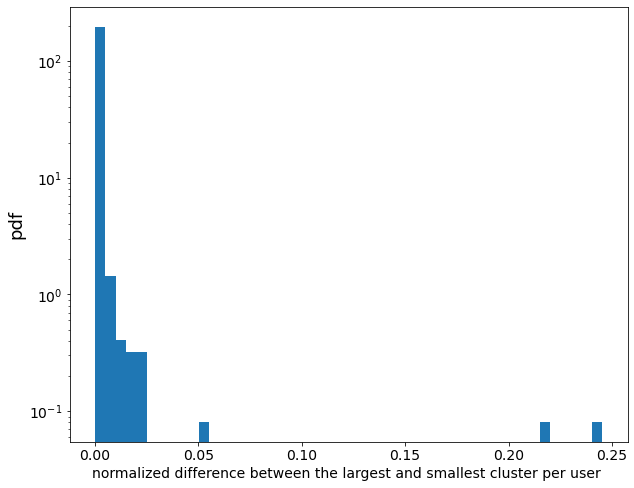

In [73]:
df_users_clusters_norm=pd.DataFrame()

len_c1=sum(df_users_clusters['C1'])
len_c2=sum(df_users_clusters['C2'])
len_c3=sum(df_users_clusters['C3'])
len_c4=sum(df_users_clusters['C4'])

df_users_clusters_norm['C1']=df_users_clusters['C1']/len_c1
df_users_clusters_norm['C2']=df_users_clusters['C2']/len_c2
df_users_clusters_norm['C3']=df_users_clusters['C3']/len_c3
df_users_clusters_norm['C4']=df_users_clusters['C4']/len_c4

df_users_clusters_norm['max count']=df_users_clusters_norm[['C1','C2','C3','C4']].max(axis=1)
df_users_clusters_norm['min count']=df_users_clusters_norm[['C1','C2','C3','C4']].min(axis=1)

df_users_clusters_norm['diff']=df_users_clusters_norm['max count']-df_users_clusters_norm['min count']


# Plot PDF
fig, ax = plt.subplots(figsize=(10,8))

diff=df_users_clusters_norm['diff'].tolist()
bins=int((max(diff)-min(diff))/0.005) # using normalized bins of 0.005 visits

df_users_clusters_norm['diff'].plot.hist(bins=bins,density=True)
ax.set_yscale('log',basey=10)
#ax.set_xscale('log',basex=10)

plt.xlabel("normalized difference between the largest and smallest cluster per user ", fontsize=14)
plt.ylabel("pdf", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

# 4. Inter-event time 

## 4.1. Inter-event time per consumption cluster

We compute the inter-event time of each cluster. Using the sorted records by date-time of each cluster, without taking into account the user

C1

Nombre de interevent times: 44811
<tau>= 367.216107652139 s
std_tau= 3823.7417390090222 s


C2

Nombre de interevent times: 39288
<tau>= 418.1954795357361 s
std_tau= 4843.490940757177 s


C3

Nombre de interevent times: 30495
<tau>= 539.3748155435318 s
std_tau= 4621.863572297073 s




<ipython-input-129-63339521626c>:44: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-129-63339521626c>:45: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)


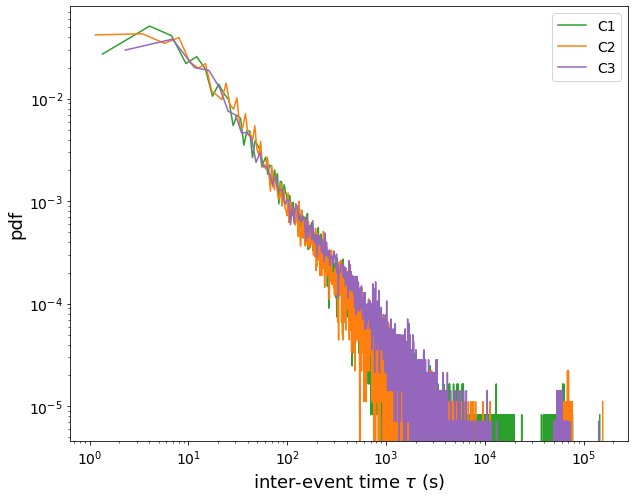

In [129]:
fig, ax1 = plt.subplots(figsize=(10,8)) 

count=0
list_labels=['C1','C2','C3']  
colors=['tab:green','tab:orange','tab:purple' ]
df['data_de_consulta'] = pd.to_datetime(df['data_de_consulta'], format = '%Y/%m/%d %H:%M:%S') 

for i,j in df.groupby('Segment'):
    print(i)
    print('')
    
    dates=j['data_de_consulta'].tolist()
    
    # Calcul de cada intervent time per un usuari en concret
    interevent_time=[]
    nombre_consulta=[]
    for p in range(1,len(j['Segment'])):
        interevent_time.append((dates[p]-dates[p-1]).total_seconds())
        nombre_consulta.append(p)
    
            
    print('Nombre de interevent times:', len(interevent_time))   # Printem el nombre de intervent times (Nombre de registres-1)
    print('<tau>=', np.mean(interevent_time),'s')                # I printem el valor mig i la desviacio estandard
    print('std_tau=', np.std(interevent_time),'s')
    print('')
    print('')
    

    #bins=int((max(j['data_de_consulta_new'])-min(j['data_de_consulta_new']))/1800.) # caixes de 30 minuts
    #hora_inici=j['data_de_consulta_new'].tolist()
    
    numpy_matrix = np.array(interevent_time)  #list to array
    counts,bin_edges = np.histogram(numpy_matrix,bins='auto',density=True)   #frequences and bins
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center

    ax1.plot(bin_centres, counts, '-', label=list_labels[count], color=colors[count])    #plot pdf
    #ax1.plot(bin_centres, counts, '-')
    count=count+1
    
    
ax1.set_xlabel(r'inter-event time $\tau$ (s)',fontsize=18)
ax1.set_ylabel('pdf',fontsize=18)

ax1.set_yscale('log',basey=10)
ax1.set_xscale('log',basex=10)
ax1.legend(fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()



## 4.2. Inter-event time temporal series per user

In [144]:
dff=df[df.id_usuari == 14317]
dff=dff.reset_index()
del dff['index']
dff

,url_visitada,id_usuari,day,data_de_consulta2,Cluster labels,Segment,data_de_consulta
0,https://www.enciclopedia.cat/user/14317/edit?p...,14317,Friday,55679.0,2,C3,2022-07-08 15:27:59
1,https://www.enciclopedia.cat/user/14317/edit?p...,14317,Friday,55707.0,2,C3,2022-07-08 15:28:27
2,https://www.enciclopedia.cat/user/14317/edit?p...,14317,Friday,55717.0,2,C3,2022-07-08 15:28:37
3,https://www.enciclopedia.cat/user/14317/edit?p...,14317,Friday,55743.0,2,C3,2022-07-08 15:29:03
4,https://www.enciclopedia.cat/user/14317/edit?p...,14317,Friday,55778.0,2,C3,2022-07-08 15:29:38
...,...,...,...,...,...,...,...
89,https://www.enciclopedia.cat/gran-enciclopedia...,14317,Friday,58163.0,2,C3,2022-07-08 16:09:23
90,https://www.enciclopedia.cat/cerca/gec?search_...,14317,Friday,58232.0,2,C3,2022-07-08 16:10:32
91,https://www.enciclopedia.cat/gran-enciclopedia...,14317,Friday,58253.0,2,C3,2022-07-08 16:10:53
92,https://www.enciclopedia.cat/cerca/gec?search_...,14317,Friday,58315.0,2,C3,2022-07-08 16:11:55


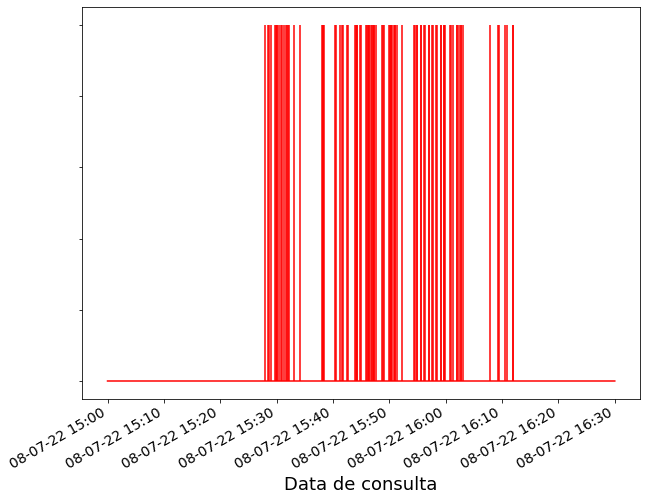

In [145]:
import matplotlib.dates as mdates

#times = pd.date_range(start='2022-05-15', end='2022-11-22', freq='1S')
times = pd.date_range(start='2022-07-08 15:00:00', end='2022-07-08 16:30:00', freq='1S')
yy= [0] * len(times)
xx=dff['data_de_consulta'].tolist()

fig, ax = plt.subplots(1,figsize=(10,8))
fig.autofmt_xdate()
plt.plot(times,yy, color='red')

xfmt = mdates.DateFormatter('%d-%m-%y %H:%M')
ax.xaxis.set_major_formatter(xfmt)

ax.vlines(x=xx, ymin=0, ymax=1, colors='red')
plt.xticks(fontsize=14)
ax.set(yticklabels=[])

ax.set_xlabel('Data de consulta',fontsize=18)

plt.show()

##  4.3. DBSCAN Algorithm using inter-event time

We clusterize the users again adding two new columns with the information of the mean inter-event time and the standard deviation for each user.


#### Sort users' dataframe by user ID

In [8]:
df_users_clusters_sorted2=df_users_clusters.sort_values(by='usuari_id',ascending=True)
df_users_clusters_sorted2=df_users_clusters_sorted2.reset_index(drop=True)
df_users_clusters_sorted2

,usuari_id,C1,C2,C3,C4,max count,max label,min count,min label,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,total_counts
0,863,11818,5791,561,0,11818,C1,0,C4,2909,4260,4740,3401,2860,0,0,18170.0
1,1444,3,0,0,0,3,C1,0,C2,0,0,0,0,3,0,0,3.0
2,1504,2491,1531,82,0,2491,C1,0,C4,675,725,1149,1013,539,0,3,4104.0
3,3064,184,138,25,0,184,C1,0,C4,78,29,47,134,41,18,0,347.0
4,3422,267,71,166,0,267,C1,0,C4,98,125,115,75,53,10,28,504.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,37127,0,0,6,0,6,C3,0,C1,6,0,0,0,0,0,0,6.0
2471,37130,0,0,10,0,10,C3,0,C1,10,0,0,0,0,0,0,10.0
2472,37152,0,0,2,0,2,C3,0,C1,2,0,0,0,0,0,0,2.0
2473,37155,0,0,5,0,5,C3,0,C1,5,0,0,0,0,0,0,5.0


####  Sort consumption/visits dataframe by date-time and obtain the mean value of the inter-event time (and the std) for each user

In [51]:
dff = df.sort_values(by='data_de_consulta',ascending=True)
dff['data_de_consulta'] = pd.to_datetime(dff['data_de_consulta'], format = '%Y/%m/%d %H:%M:%S') 
dff

llista_users=[]
llista_taus=[]    # List of average values of tau for each user
llista_std_taus=[]  # List of standard deviations of tau for each user
temps_entre_inici_final=[]

for i,j in dff.groupby('id_usuari'):    # Loop over each user ID
    print('User ID: {}'.format(i))           
    print('')
    print('This user have {} records'.format(len(j['id_usuari'])))
    print('')

    dates=j['data_de_consulta'].tolist()
    
    # Obtain the inter-event times of each user
    interevent_time=[]
    nombre_consulta=[]
    for p in range(1,len(j['id_usuari'])):
        interevent_time.append((dates[p]-dates[p-1]).total_seconds())
        nombre_consulta.append(p) # We store the number of visit (1 for the first, 2 for the second...) for representation
        
    # Print <tau> and sigma
    print('The average value of the inter-event time is <tau>= {} seconds'.format(np.mean(interevent_time)))
    print('The standard deviation of tau is sigma= {} seconds'.format(np.std(interevent_time)))
    
    llista_taus.append(np.mean(interevent_time))
    llista_std_taus.append(np.std(interevent_time))
    llista_users.append(i)
    
    temps_entre_inici_final.append((dates[-1]-dates[0]).total_seconds())  

df_users_clusters_sorted2['mean_tau']=llista_taus
df_users_clusters_sorted2['std_tau']=llista_std_taus
df_users_clusters_sorted2['temps_entre_inici_final']=temps_entre_inici_final
df_users_clusters_sorted2

User ID: 863

This user have 18170 records

The average value of the inter-event time is <tau>= 900.5368484781771 seconds
The standard deviation of tau is sigma= 18382.923329456968 seconds
User ID: 1444

This user have 3 records

The average value of the inter-event time is <tau>= 1210.0 seconds
The standard deviation of tau is sigma= 1186.0 seconds
User ID: 1504

This user have 4104 records

The average value of the inter-event time is <tau>= 3987.2970996831586 seconds
The standard deviation of tau is sigma= 40139.613149810444 seconds
User ID: 3064

This user have 347 records

The average value of the inter-event time is <tau>= 45719.274566473985 seconds
The standard deviation of tau is sigma= 303411.6519914137 seconds
User ID: 3422

This user have 504 records

The average value of the inter-event time is <tau>= 30667.298210735586 seconds
The standard deviation of tau is sigma= 209432.03686902323 seconds
User ID: 3522

This user have 5635 records

The average value of the inter-event 

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The standard deviation of tau is sigma= 106205.15590202405 seconds
User ID: 11729

This user have 10 records

The average value of the inter-event time is <tau>= 51.0 seconds
The standard deviation of tau is sigma= 49.55132019768327 seconds
User ID: 11732

This user have 3 records

The average value of the inter-event time is <tau>= 43.5 seconds
The standard deviation of tau is sigma= 4.5 seconds
User ID: 11744

This user have 29 records

The average value of the inter-event time is <tau>= 162673.57142857142 seconds
The standard deviation of tau is sigma= 830105.245754951 seconds
User ID: 11819

This user have 16 records

The average value of the inter-event time is <tau>= 569756.0666666667 seconds
The standard deviation of tau is sigma= 2110956.138289613 seconds
User ID: 11829

This user have 5 records

The average value of the inter-event time is <tau>= 92.5 seconds
The standard deviation of tau is sigma= 42.29952718411874 seconds
User ID: 11916

This user have 9 records

The average

The average value of the inter-event time is <tau>= 210159.02 seconds
The standard deviation of tau is sigma= 1170306.9131446758 seconds
User ID: 17453

This user have 4 records

The average value of the inter-event time is <tau>= 17.333333333333332 seconds
The standard deviation of tau is sigma= 15.326085243430198 seconds
User ID: 17457

This user have 5 records

The average value of the inter-event time is <tau>= 30.0 seconds
The standard deviation of tau is sigma= 3.391164991562634 seconds
User ID: 17484

This user have 43 records

The average value of the inter-event time is <tau>= 52.57142857142857 seconds
The standard deviation of tau is sigma= 80.64328946697565 seconds
User ID: 17808

This user have 6 records

The average value of the inter-event time is <tau>= 502613.6 seconds
The standard deviation of tau is sigma= 1005202.7000056456 seconds
User ID: 17826

This user have 5 records

The average value of the inter-event time is <tau>= 418.75 seconds
The standard deviation of ta

The standard deviation of tau is sigma= 29379.493467197717 seconds
User ID: 20332

This user have 953 records

The average value of the inter-event time is <tau>= 17155.298319327732 seconds
The standard deviation of tau is sigma= 131275.84576632179 seconds
User ID: 20333

This user have 10 records

The average value of the inter-event time is <tau>= 42.22222222222222 seconds
The standard deviation of tau is sigma= 47.73486444885559 seconds
User ID: 20339

This user have 37 records

The average value of the inter-event time is <tau>= 235527.36111111112 seconds
The standard deviation of tau is sigma= 970799.3648502349 seconds
User ID: 20340

This user have 418 records

The average value of the inter-event time is <tau>= 12843.664268585131 seconds
The standard deviation of tau is sigma= 142414.94102109075 seconds
User ID: 20341

This user have 4 records

The average value of the inter-event time is <tau>= 43.666666666666664 seconds
The standard deviation of tau is sigma= 11.84154644555440

The average value of the inter-event time is <tau>= 2478.3603022893976 seconds
The standard deviation of tau is sigma= 59098.035661568334 seconds
User ID: 21855

This user have 29 records

The average value of the inter-event time is <tau>= 39349.857142857145 seconds
The standard deviation of tau is sigma= 204341.2257452006 seconds
User ID: 21859

This user have 5 records

The average value of the inter-event time is <tau>= 30.75 seconds
The standard deviation of tau is sigma= 19.84155991851447 seconds
User ID: 21897

This user have 71 records

The average value of the inter-event time is <tau>= 38432.05714285714 seconds
The standard deviation of tau is sigma= 199364.17953146415 seconds
User ID: 21904

This user have 107 records

The average value of the inter-event time is <tau>= 132683.8962264151 seconds
The standard deviation of tau is sigma= 1332748.1921761339 seconds
User ID: 22019

This user have 48 records

The average value of the inter-event time is <tau>= 297807.7021276596 se

This user have 15 records

The average value of the inter-event time is <tau>= 369368.9285714286 seconds
The standard deviation of tau is sigma= 1290473.15016799 seconds
User ID: 26258

This user have 5 records

The average value of the inter-event time is <tau>= 2374.0 seconds
The standard deviation of tau is sigma= 3939.445075134314 seconds
User ID: 26350

This user have 9 records

The average value of the inter-event time is <tau>= 14.25 seconds
The standard deviation of tau is sigma= 21.317539726713306 seconds
User ID: 26445

This user have 8 records

The average value of the inter-event time is <tau>= 150.85714285714286 seconds
The standard deviation of tau is sigma= 262.3805461927545 seconds
User ID: 26446

This user have 4 records

The average value of the inter-event time is <tau>= 32939.0 seconds
The standard deviation of tau is sigma= 46570.759717516594 seconds
User ID: 26447

This user have 2 records

The average value of the inter-event time is <tau>= 39.0 seconds
The stand

This user have 6 records

The average value of the inter-event time is <tau>= 15653.0 seconds
The standard deviation of tau is sigma= 31281.001818995504 seconds
User ID: 29387

This user have 5 records

The average value of the inter-event time is <tau>= 13.75 seconds
The standard deviation of tau is sigma= 13.663363421939708 seconds
User ID: 29421

This user have 7 records

The average value of the inter-event time is <tau>= 32.333333333333336 seconds
The standard deviation of tau is sigma= 20.885933597094056 seconds
User ID: 29436

This user have 21 records

The average value of the inter-event time is <tau>= 11.8 seconds
The standard deviation of tau is sigma= 10.00299955013495 seconds
User ID: 29458

This user have 4 records

The average value of the inter-event time is <tau>= 8.666666666666666 seconds
The standard deviation of tau is sigma= 7.408703590297622 seconds
User ID: 29463

This user have 18 records

The average value of the inter-event time is <tau>= 562719.7647058824 sec

The standard deviation of tau is sigma= 0.0 seconds
User ID: 32655

This user have 3 records

The average value of the inter-event time is <tau>= 10.5 seconds
The standard deviation of tau is sigma= 3.5 seconds
User ID: 32657

This user have 14 records

The average value of the inter-event time is <tau>= 38.61538461538461 seconds
The standard deviation of tau is sigma= 31.757587734244314 seconds
User ID: 32658

This user have 12 records

The average value of the inter-event time is <tau>= 9.727272727272727 seconds
The standard deviation of tau is sigma= 5.327303754175858 seconds
User ID: 32660

This user have 23 records

The average value of the inter-event time is <tau>= 13.909090909090908 seconds
The standard deviation of tau is sigma= 25.444965729820417 seconds
User ID: 32663

This user have 52 records

The average value of the inter-event time is <tau>= 52477.82352941176 seconds
The standard deviation of tau is sigma= 223708.74270036185 seconds
User ID: 32665

This user have 32 rec

This user have 100 records

The average value of the inter-event time is <tau>= 19369.59595959596 seconds
The standard deviation of tau is sigma= 110696.88493978546 seconds
User ID: 34318

This user have 10 records

The average value of the inter-event time is <tau>= 47.55555555555556 seconds
The standard deviation of tau is sigma= 75.55147047780093 seconds
User ID: 34319

This user have 12 records

The average value of the inter-event time is <tau>= 30058.909090909092 seconds
The standard deviation of tau is sigma= 55237.83141759828 seconds
User ID: 34320

This user have 18 records

The average value of the inter-event time is <tau>= 69.3529411764706 seconds
The standard deviation of tau is sigma= 73.84557908346991 seconds
User ID: 34321

This user have 10 records

The average value of the inter-event time is <tau>= 25.444444444444443 seconds
The standard deviation of tau is sigma= 22.56403781394491 seconds
User ID: 34322

This user have 9 records

The average value of the inter-event

The average value of the inter-event time is <tau>= 16.0 seconds
The standard deviation of tau is sigma= 5.715476066494082 seconds
User ID: 34752

This user have 16 records

The average value of the inter-event time is <tau>= 448.2 seconds
The standard deviation of tau is sigma= 1148.0003600464013 seconds
User ID: 34753

This user have 3 records

The average value of the inter-event time is <tau>= 13.0 seconds
The standard deviation of tau is sigma= 2.0 seconds
User ID: 34754

This user have 9 records

The average value of the inter-event time is <tau>= 23784.125 seconds
The standard deviation of tau is sigma= 62841.8469561436 seconds
User ID: 34755

This user have 16 records

The average value of the inter-event time is <tau>= 64684.2 seconds
The standard deviation of tau is sigma= 241931.24000624643 seconds
User ID: 34756

This user have 8 records

The average value of the inter-event time is <tau>= 22.571428571428573 seconds
The standard deviation of tau is sigma= 13.875540070386375

The average value of the inter-event time is <tau>= 12012.846153846154 seconds
The standard deviation of tau is sigma= 41426.4118776084 seconds
User ID: 35066

This user have 6 records

The average value of the inter-event time is <tau>= 178.4 seconds
The standard deviation of tau is sigma= 322.4125307738519 seconds
User ID: 35067

This user have 20 records

The average value of the inter-event time is <tau>= 3196.4210526315787 seconds
The standard deviation of tau is sigma= 12253.07667621651 seconds
User ID: 35068

This user have 3 records

The average value of the inter-event time is <tau>= 174.0 seconds
The standard deviation of tau is sigma= 145.0 seconds
User ID: 35069

This user have 38 records

The average value of the inter-event time is <tau>= 7094.243243243243 seconds
The standard deviation of tau is sigma= 41194.88323409307 seconds
User ID: 35070

This user have 6 records

The average value of the inter-event time is <tau>= 19.8 seconds
The standard deviation of tau is sigma

This user have 25 records

The average value of the inter-event time is <tau>= 233.91666666666666 seconds
The standard deviation of tau is sigma= 885.130730300458 seconds
User ID: 35447

This user have 12 records

The average value of the inter-event time is <tau>= 194.72727272727272 seconds
The standard deviation of tau is sigma= 476.1617545844328 seconds
User ID: 35448

This user have 2 records

The average value of the inter-event time is <tau>= 13.0 seconds
The standard deviation of tau is sigma= 0.0 seconds
User ID: 35449

This user have 15 records

The average value of the inter-event time is <tau>= 301.64285714285717 seconds
The standard deviation of tau is sigma= 628.2105660573709 seconds
User ID: 35450

This user have 51 records

The average value of the inter-event time is <tau>= 1600.78 seconds
The standard deviation of tau is sigma= 5338.496984320586 seconds
User ID: 35451

This user have 4 records

The average value of the inter-event time is <tau>= 1413.0 seconds
The stan

The average value of the inter-event time is <tau>= 15.0 seconds
The standard deviation of tau is sigma= 14.236104336041748 seconds
User ID: 35988

This user have 15 records

The average value of the inter-event time is <tau>= 90251.21428571429 seconds
The standard deviation of tau is sigma= 266444.9156947772 seconds
User ID: 35989

This user have 22 records

The average value of the inter-event time is <tau>= 74376.85714285714 seconds
The standard deviation of tau is sigma= 309413.4256420543 seconds
User ID: 35990

This user have 2 records

The average value of the inter-event time is <tau>= 19.0 seconds
The standard deviation of tau is sigma= 0.0 seconds
User ID: 35991

This user have 9 records

The average value of the inter-event time is <tau>= 340.125 seconds
The standard deviation of tau is sigma= 536.2199729355482 seconds
User ID: 35992

This user have 6 records

The average value of the inter-event time is <tau>= 314.2 seconds
The standard deviation of tau is sigma= 595.4623077

This user have 5 records

The average value of the inter-event time is <tau>= 47.0 seconds
The standard deviation of tau is sigma= 48.31666379211214 seconds
User ID: 36739

This user have 14 records

The average value of the inter-event time is <tau>= 6918.923076923077 seconds
The standard deviation of tau is sigma= 17026.27195502264 seconds
User ID: 36741

This user have 22 records

The average value of the inter-event time is <tau>= 21671.0 seconds
The standard deviation of tau is sigma= 96181.5520406714 seconds
User ID: 36742

This user have 62 records

The average value of the inter-event time is <tau>= 10129.508196721312 seconds
The standard deviation of tau is sigma= 41979.7014627983 seconds
User ID: 36743

This user have 8 records

The average value of the inter-event time is <tau>= 1254.7142857142858 seconds
The standard deviation of tau is sigma= 2762.4132159237515 seconds
User ID: 36744

This user have 3 records

The average value of the inter-event time is <tau>= 28.5 second

,usuari_id,C1,C2,C3,C4,max count,max label,min count,min label,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,total_counts,mean_tau,std_tau,temps_entre_inici_final
0,863,11818,5791,561,0,11818,C1,0,C4,2909,4260,4740,3401,2860,0,0,18170.0,900.536848,18382.923329,16361854.0
1,1444,3,0,0,0,3,C1,0,C2,0,0,0,0,3,0,0,3.0,1210.000000,1186.000000,2420.0
2,1504,2491,1531,82,0,2491,C1,0,C4,675,725,1149,1013,539,0,3,4104.0,3987.297100,40139.613150,16359880.0
3,3064,184,138,25,0,184,C1,0,C4,78,29,47,134,41,18,0,347.0,45719.274566,303411.651991,15818869.0
4,3422,267,71,166,0,267,C1,0,C4,98,125,115,75,53,10,28,504.0,30667.298211,209432.036869,15425651.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,37127,0,0,6,0,6,C3,0,C1,6,0,0,0,0,0,0,6.0,14.000000,4.000000,70.0
2471,37130,0,0,10,0,10,C3,0,C1,10,0,0,0,0,0,0,10.0,10.111111,9.562013,91.0
2472,37152,0,0,2,0,2,C3,0,C1,2,0,0,0,0,0,0,2.0,18.000000,0.000000,18.0
2473,37155,0,0,5,0,5,C3,0,C1,5,0,0,0,0,0,0,5.0,11.500000,6.982120,46.0


In [55]:
df33=df_users_clusters_sorted2.copy()        # Make a copy of the data-set with only the columns to clusterize (2475x11)

del df33['max count']
del df33['max label']
del df33['min count']
del df33['min label']
del df33['usuari_id']
del df33['C4']
del df33['total_counts']

df33['mean_tau'] = df33['mean_tau'].fillna(0)
df33['std_tau'] = df33['std_tau'].fillna(0)
df33['temps_entre_inici_final'] =df33['temps_entre_inici_final'].fillna(0)

del df33['temps_entre_inici_final']
df33

,C1,C2,C3,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,mean_tau,std_tau
0,11818,5791,561,2909,4260,4740,3401,2860,0,0,900.536848,18382.923329
1,3,0,0,0,0,0,0,3,0,0,1210.000000,1186.000000
2,2491,1531,82,675,725,1149,1013,539,0,3,3987.297100,40139.613150
3,184,138,25,78,29,47,134,41,18,0,45719.274566,303411.651991
4,267,71,166,98,125,115,75,53,10,28,30667.298211,209432.036869
...,...,...,...,...,...,...,...,...,...,...,...,...
2470,0,0,6,6,0,0,0,0,0,0,14.000000,4.000000
2471,0,0,10,10,0,0,0,0,0,0,10.111111,9.562013
2472,0,0,2,2,0,0,0,0,0,0,18.000000,0.000000
2473,0,0,5,5,0,0,0,0,0,0,11.500000,6.982120


####  DBSCAN. StandardScaler + Algorithm

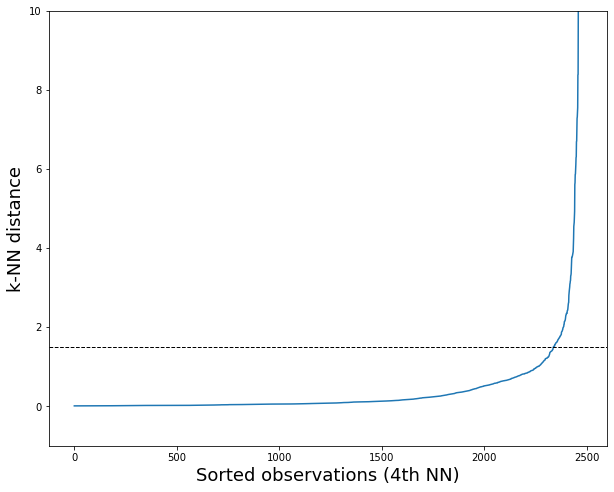

In [56]:
from sklearn.preprocessing import StandardScaler

scaler2 = StandardScaler()
scaled_features2 = scaler2.fit_transform(df33)  # Use the StandardScaler with returns the columns with zero mean and unit variance
        

from sklearn.neighbors import NearestNeighbors

# n_neighbors = 22 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs2 = NearestNeighbors(n_neighbors=24).fit(scaled_features2)

# Find the k-neighbors of a point
neigh_dist2, neigh_ind2 = nbrs2.kneighbors(scaled_features2)

# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist2 = np.sort(neigh_dist2, axis=0)


# Now, get the sorted kth column (distances with kth neighbors) and plot the kNN distance plot
k_dist2 = sort_neigh_dist2[:, 23]

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(k_dist2)
plt.axhline(y=1.5, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance", fontsize=18)
plt.xlabel("Sorted observations (4th NN)",fontsize=18)
plt.ylim(-1,10)
plt.show()

In [60]:
from sklearn.cluster import DBSCAN

clusters2 = DBSCAN(eps=1.5, min_samples=24).fit(scaled_features2)


df_dbscan2=df33.copy()
df_dbscan2['Clusters']=clusters2.labels_

df_dbscan2['Segment'] = df_dbscan2['Clusters'].map({-1:'C2 DBSCAN', 0:'C1 DBSCAN'})
df_dbscan2['Segment'] = df_dbscan2['Segment'].astype('category')
df_dbscan2['user_id']=df_users_clusters['usuari_id']
df_dbscan2['total_counts'] = df_dbscan2[['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday','Saturday','Sunday']].astype(float).sum(1)
df_dbscan2['temps_entre_inici_final']=temps_entre_inici_final
df_dbscan2

,C1,C2,C3,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,mean_tau,std_tau,Clusters,Segment,user_id,total_counts,temps_entre_inici_final
0,11818,5791,561,2909,4260,4740,3401,2860,0,0,900.536848,18382.923329,-1,C2 DBSCAN,863,18170.0,16361854.0
1,3,0,0,0,0,0,0,3,0,0,1210.000000,1186.000000,0,C1 DBSCAN,1444,3.0,2420.0
2,2491,1531,82,675,725,1149,1013,539,0,3,3987.297100,40139.613150,-1,C2 DBSCAN,1504,4104.0,16359880.0
3,184,138,25,78,29,47,134,41,18,0,45719.274566,303411.651991,0,C1 DBSCAN,3064,347.0,15818869.0
4,267,71,166,98,125,115,75,53,10,28,30667.298211,209432.036869,-1,C2 DBSCAN,3422,504.0,15425651.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,0,0,6,6,0,0,0,0,0,0,14.000000,4.000000,0,C1 DBSCAN,37127,6.0,70.0
2471,0,0,10,10,0,0,0,0,0,0,10.111111,9.562013,0,C1 DBSCAN,37130,10.0,91.0
2472,0,0,2,2,0,0,0,0,0,0,18.000000,0.000000,0,C1 DBSCAN,37152,2.0,18.0
2473,0,0,5,5,0,0,0,0,0,0,11.500000,6.982120,0,C1 DBSCAN,37155,5.0,46.0


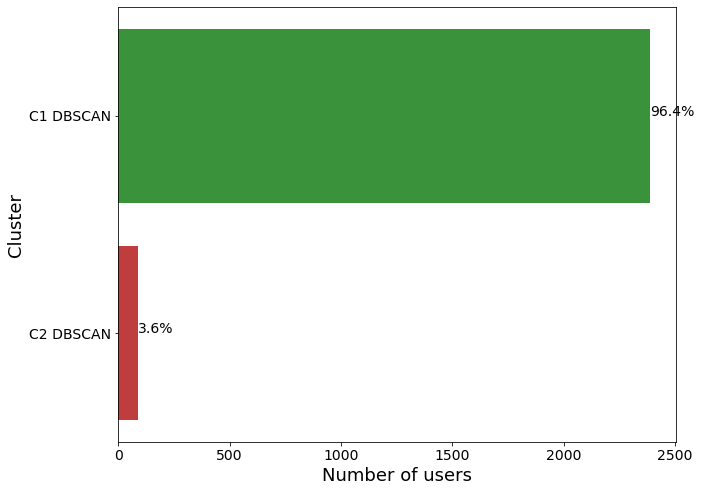

C1 DBSCAN    2386
C2 DBSCAN      89
Name: Segment, dtype: int64

In [61]:
fig, ax = plt.subplots(figsize=(10,8))
colors=['tab:green','tab:red','tab:purple','tab:orange' ]
ax = sns.countplot(y=df_dbscan2['Segment'], data=df_dbscan2['Segment'],order = df_dbscan2['Segment'].value_counts().index, palette=colors)
plt.xlabel('Number of users',fontsize=18)
plt.ylabel('Cluster',fontsize=18)


total = sum(df_dbscan2['Segment'].value_counts())
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    value=p.get_width()
    x = p.get_x() + p.get_width() + 0.1
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y),fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

df_dbscan2['Segment'].value_counts()

## 4.4. Clustering interpretation

### 4.4.1. Users in each DBSCAN cluster 

<ipython-input-17-b1d4fdf13076>:13: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log',basex=10)
<ipython-input-17-b1d4fdf13076>:14: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('log',basey=10)


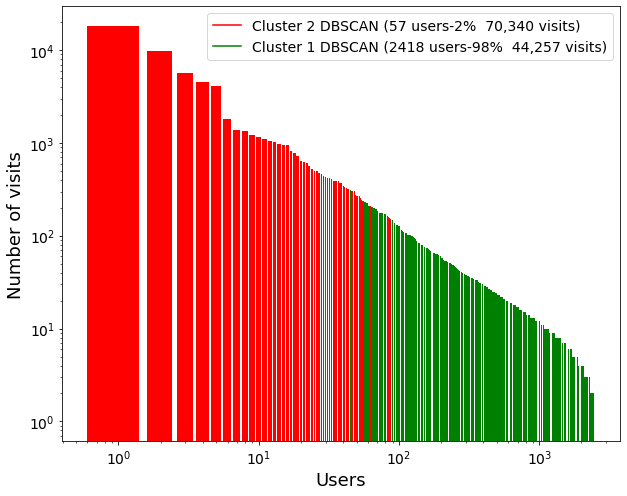

In [17]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D   # To set manually the legend

counts_users2=sorted_df_dbscan2['total_counts'].tolist() # Counts (number of visits) of each user
colors2=sorted_df_dbscan2['color'].tolist()  # Colors to list (red for C1 and green for C2)
users2= list(range(1,len(counts_users2)+1))  # Create a list from 1 to length of the users 

# Bar-Plot of users vs number of visits, sorted by frequency. Users belonging to C1 are colored in red and C2 in green.
fig, ax = plt.subplots(figsize=(10,8))
for i in range(len(users2)):
    ax.bar(users2[i],counts_users2[i], color=colors2[i])

ax.set_xscale('log',basex=10)
ax.set_yscale('log',basey=10)
ax.set_xlabel('Users',fontsize=18)
ax.set_ylabel('Number of visits',fontsize=18)


# We set manually the legend
handles, labels = plt.gca().get_legend_handles_labels()
#define patches and lines to add to legend
line1 = Line2D([0], [0], label='Cluster 2 DBSCAN (57 users-2%  70,340 visits)', color='red')
line2 = Line2D([0], [0], label='Cluster 1 DBSCAN (2418 users-98%  44,257 visits)', color='green')

#add handles
handles.extend([line1, line2])

#add legend
plt.legend(handles=handles, fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()



<ipython-input-62-7a4382584371>:17: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log',basex=10)


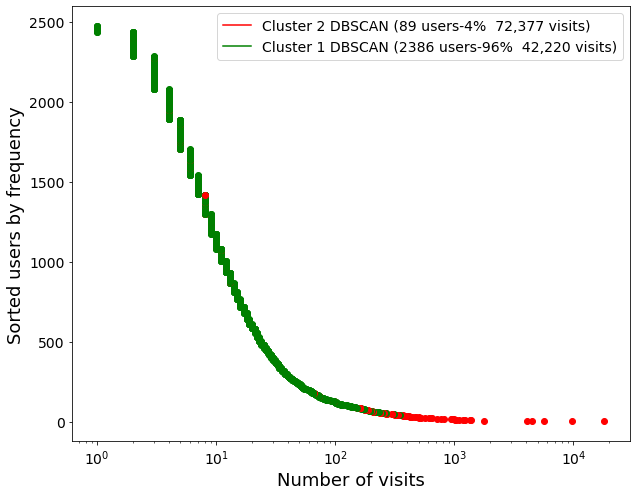

In [62]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D   # To set manually the legend

sorted_df_dbscan2 = df_dbscan2.sort_values(by='total_counts',ascending=False)  # Sort by total counts (frequency). New Data-Frame
sorted_df_dbscan2["color"] = np.where(sorted_df_dbscan2["Segment"]=="C1 DBSCAN", "green", "red") # Add color column (red C1, green C2)
sorted_df_dbscan2

counts_users2=sorted_df_dbscan2['total_counts'].tolist() # Counts (number of visits) of each user
colors2=sorted_df_dbscan2['color'].tolist()  # Colors to list (red for C1 and green for C2)
users2= list(range(1,len(counts_users2)+1))  # Create a list from 1 to length of the users 

# Bar-Plot of users vs number of visits, sorted by frequency. Users belonging to C1 are colored in red and C2 in green.
fig, ax = plt.subplots(figsize=(10,8))
for i in range(len(users2)):
    ax.scatter(counts_users2[i],users2[i], color=colors2[i])

ax.set_xscale('log',basex=10)
#ax.set_yscale('log',basey=10)
ax.set_ylabel('Sorted users by frequency',fontsize=18)
ax.set_xlabel('Number of visits',fontsize=18)


# We set manually the legend
handles, labels = plt.gca().get_legend_handles_labels()
#define patches and lines to add to legend
line1 = Line2D([0], [0], label='Cluster 2 DBSCAN (89 users-4%  72,377 visits)', color='red')
line2 = Line2D([0], [0], label='Cluster 1 DBSCAN (2386 users-96%  42,220 visits)', color='green')

#add handles
handles.extend([line1, line2])

#add legend
plt.legend(handles=handles, fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()



### 4.4.2. Mean inter-event time and standard deviation of each user

<ipython-input-63-bdd739cbe401>:20: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-63-bdd739cbe401>:21: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)


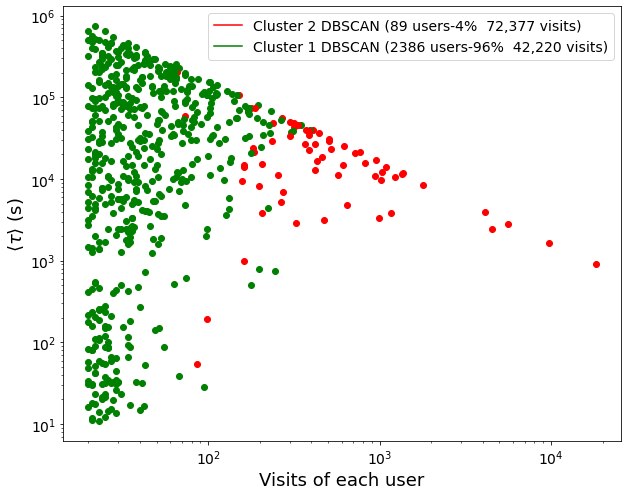

<ipython-input-63-bdd739cbe401>:45: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-63-bdd739cbe401>:46: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)


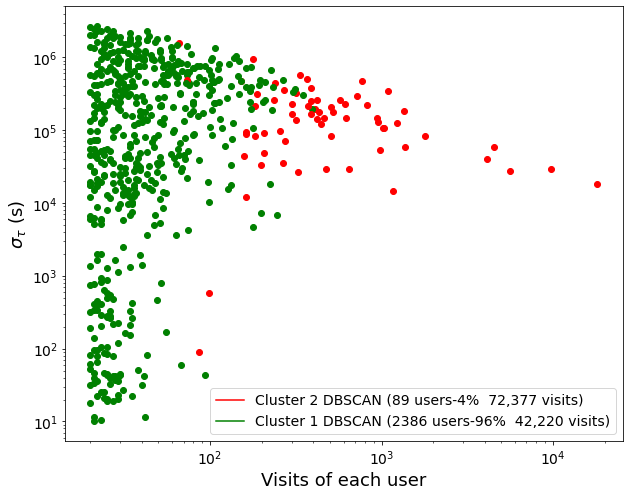

In [63]:
# The first 200 users (with more visits)

sorted_df_dbscan2['code'] = pd.factorize(sorted_df_dbscan2['total_counts'])[0] + 1   # Code user ID for representation

# Value of the average value of the inter-event time <tau>

mean_taus=sorted_df_dbscan2['mean_tau'].tolist()
std_taus=sorted_df_dbscan2['std_tau'].tolist()
colors2=sorted_df_dbscan2['color'].tolist()  # Colors to list (red for C1 and green for C2)
users2= list(range(1,len(mean_taus)+1))  # Create a list from 1 to length of the users 
visits_per_usuari=sorted_df_dbscan2['total_counts'].tolist()

fig, ax1 = plt.subplots(figsize=(10,8)) 
for i in range(len(users2)):
    if visits_per_usuari[i]>=20:
        ax1.scatter(visits_per_usuari[i],mean_taus[i], color=colors2[i])

ax1.set_ylabel(r'$\langle \tau \rangle$ (s)',fontsize=18)
ax1.set_xlabel('Visits of each user',fontsize=18)
ax1.set_yscale('log',basey=10)
ax1.set_xscale('log',basex=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# We set manually the legend
handles, labels = plt.gca().get_legend_handles_labels()
#define patches and lines to add to legend
line1 = Line2D([0], [0], label='Cluster 2 DBSCAN (89 users-4%  72,377 visits)', color='red')
line2 = Line2D([0], [0], label='Cluster 1 DBSCAN (2386 users-96%  42,220 visits)', color='green')

#add handles
handles.extend([line1, line2])

#add legend
plt.legend(handles=handles, fontsize=14)
plt.show()


fig, ax1 = plt.subplots(figsize=(10,8)) 
for i in range(len(users2)):
    if visits_per_usuari[i]>=20:
        ax1.scatter(visits_per_usuari[i],std_taus[i], color=colors2[i])

ax1.set_ylabel(r'$\sigma_{\tau}$ (s)',fontsize=18)
ax1.set_xlabel('Visits of each user',fontsize=18)
ax1.set_yscale('log',basey=10)
ax1.set_xscale('log',basex=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# We set manually the legend
handles, labels = plt.gca().get_legend_handles_labels()
#define patches and lines to add to legend
line1 = Line2D([0], [0], label='Cluster 2 DBSCAN (89 users-4%  72,377 visits)', color='red')
line2 = Line2D([0], [0], label='Cluster 1 DBSCAN (2386 users-96%  42,220 visits)', color='green')

#add handles
handles.extend([line1, line2])

#add legend
plt.legend(handles=handles, fontsize=14)
plt.show()
 


In [64]:
df_c11= df_dbscan2.loc[df_dbscan2['Segment'] == 'C1 DBSCAN']   # Only those users belonging to C1
df_c11['total_counts'] = df_c11[['C1', 'C2', 'C3']].astype(float).sum(1)   # Add new column with the total visits
print('The number of consumption units/visits in C1 DBSCAN is {} ({} % of the total)'.format(sum(df_c11['total_counts']), 
                                                                                     sum(df_c11['total_counts'])*100/114597))

The number of consumption units/visits in C1 DBSCAN is 42220.0 (36.842151190694345 % of the total)


<ipython-input-64-d579f5e7a8f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c11['total_counts'] = df_c11[['C1', 'C2', 'C3']].astype(float).sum(1)   # Add new column with the total visits


In [65]:
df_c22= df_dbscan2.loc[df_dbscan2['Segment'] == 'C2 DBSCAN']   # Only those users belonging to C1
df_c22['total_counts'] = df_c22[['C1', 'C2', 'C3']].astype(float).sum(1)   # Add new column with the total visits
print('The number of consumption units/visits in C2 DBSCAN is {} ({} % of the total)'.format(sum(df_c22['total_counts']), 
                                                                                     sum(df_c22['total_counts'])*100/114597))

The number of consumption units/visits in C2 DBSCAN is 72377.0 (63.157848809305655 % of the total)


<ipython-input-65-75257f65bb82>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c22['total_counts'] = df_c22[['C1', 'C2', 'C3']].astype(float).sum(1)   # Add new column with the total visits


#### Normalization by the time window for each user

<ipython-input-76-0d77b2e02650>:36: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-76-0d77b2e02650>:37: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)


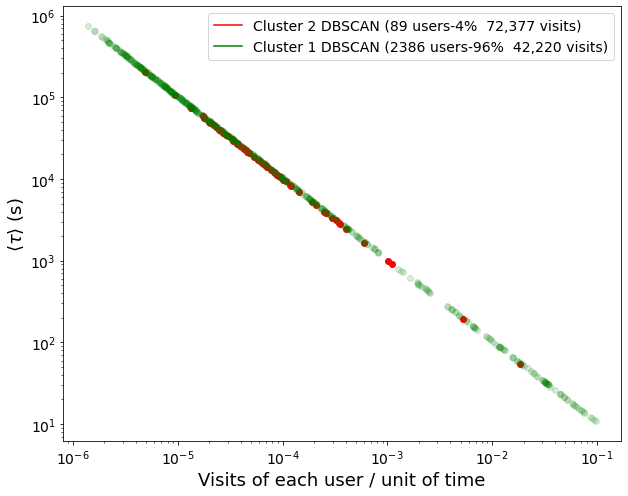

<ipython-input-76-0d77b2e02650>:64: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-76-0d77b2e02650>:65: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)


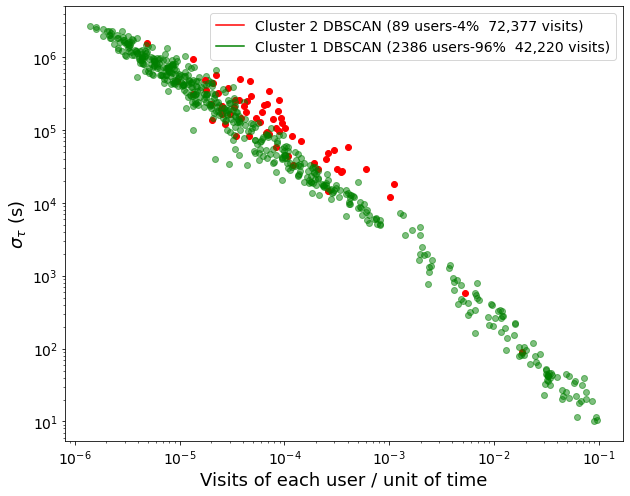

In [76]:
sorted_df_dbscan2['code'] = pd.factorize(sorted_df_dbscan2['total_counts'])[0] + 1   # Code user ID for representation

# Value of the average value of the inter-event time <tau>

mean_taus=sorted_df_dbscan2['mean_tau'].tolist()
std_taus=sorted_df_dbscan2['std_tau'].tolist()
colors2=sorted_df_dbscan2['color'].tolist()  # Colors to list (red for C1 and green for C2)
users2= list(range(1,len(mean_taus)+1))  # Create a list from 1 to length of the users 
visits_per_usuari=sorted_df_dbscan2['total_counts'].tolist()
temps_entre_inici_final=sorted_df_dbscan2['temps_entre_inici_final'].tolist()

visits_per_usuari_norm=[]
mean_taus_norm=[]
std_taus_norm=[]
colors22=[]
for j in range(len(visits_per_usuari)):
    if visits_per_usuari[j]>=20:
        visits_per_usuari_norm.append(visits_per_usuari[j]/temps_entre_inici_final[j])
        mean_taus_norm.append(mean_taus[j])
        std_taus_norm.append(std_taus[j])
        colors22.append(colors2[j])

fig, ax1 = plt.subplots(figsize=(10,8)) 
for i in range(len(visits_per_usuari_norm)):
    if colors22[i]=='green':
        alpha=0.15
    else:
        alpha=1.
    
    ax1.scatter(visits_per_usuari_norm[i],mean_taus_norm[i], color=colors22[i],alpha=alpha)

ax1.set_ylabel(r'$\langle \tau \rangle$ (s)',fontsize=18)
ax1.set_xlabel('Visits of each user / unit of time',fontsize=18)
ax1.set_yscale('log',basey=10)
ax1.set_xscale('log',basex=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# We set manually the legend
handles, labels = plt.gca().get_legend_handles_labels()
#define patches and lines to add to legend
line1 = Line2D([0], [0], label='Cluster 2 DBSCAN (89 users-4%  72,377 visits)', color='red')
line2 = Line2D([0], [0], label='Cluster 1 DBSCAN (2386 users-96%  42,220 visits)', color='green')

#add handles
handles.extend([line1, line2])

#add legend
plt.legend(handles=handles, fontsize=14)
plt.show()


fig, ax1 = plt.subplots(figsize=(10,8)) 
for i in range(len(visits_per_usuari_norm)):
    if colors22[i]=='green':
        alpha=0.5
    else:
        alpha=1.
    ax1.scatter(visits_per_usuari_norm[i],std_taus_norm[i], color=colors22[i],alpha=alpha)

ax1.set_ylabel(r'$\sigma_{\tau}$ (s)',fontsize=18)
ax1.set_xlabel('Visits of each user / unit of time',fontsize=18)
ax1.set_yscale('log',basey=10)
ax1.set_xscale('log',basex=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# We set manually the legend
handles, labels = plt.gca().get_legend_handles_labels()
#define patches and lines to add to legend
line1 = Line2D([0], [0], label='Cluster 2 DBSCAN (89 users-4%  72,377 visits)', color='red')
line2 = Line2D([0], [0], label='Cluster 1 DBSCAN (2386 users-96%  42,220 visits)', color='green')

#add handles
handles.extend([line1, line2])

#add legend
plt.legend(handles=handles, fontsize=14)
plt.show()
 


### 4.4.3.  Mean inter-event time and standard deviation of each DBSCAN cluster

In [25]:
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
     
    return "%d:%02d:%02d" % (hour, minutes, seconds)

mean_tau_c1_dbscan=df_c11['mean_tau'].tolist()
std_tau_c1_dbscan=df_c11['std_tau'].tolist()

mean_tau_c2_dbscan=df_c22['mean_tau'].tolist()
std_tau_c2_dbscan=df_c22['std_tau'].tolist()

print('C1 DBSCAN (2386 users, 96% and 42220 visits')
print('<tau>=',np.mean(mean_tau_c1_dbscan), '--->', convert(np.mean(mean_tau_c1_dbscan)))
print('<std tau>=',np.std(std_tau_c1_dbscan))
print('')

print('C2 DBSCAN (89 users, 4% and 72377 visits')
print('<tau>=',np.mean(mean_tau_c2_dbscan), '--->', convert(np.mean(mean_tau_c2_dbscan)))
print('<std tau>=',np.std(std_tau_c2_dbscan))

,url_visitada,id_usuari,day,data_de_consulta2,Cluster labels,Segment,data_de_consulta
0,https://www.enciclopedia.cat/,10451,Sunday,2021.0,0,C1,2022-05-15 00:33:41
1,https://www.enciclopedia.cat/cerca/gec?search_...,10451,Sunday,2033.0,0,C1,2022-05-15 00:33:53
2,https://www.enciclopedia.cat/catalunya-romanic...,10451,Sunday,2054.0,0,C1,2022-05-15 00:34:14
3,https://www.enciclopedia.cat/cerca/gec?search_...,10451,Sunday,2061.0,0,C1,2022-05-15 00:34:21
4,https://www.enciclopedia.cat/catalunya-romanic...,10451,Sunday,2066.0,0,C1,2022-05-15 00:34:26
...,...,...,...,...,...,...,...
114592,https://www.enciclopedia.cat/,37174,Monday,85271.0,2,C3,2022-11-21 23:41:11
114593,https://www.enciclopedia.cat/catalunya-romanic...,37174,Monday,85310.0,2,C3,2022-11-21 23:41:50
114594,https://www.enciclopedia.cat/user/37174,37174,Monday,85316.0,2,C3,2022-11-21 23:41:56
114595,https://www.enciclopedia.cat/user/37174/edit,37174,Monday,85329.0,2,C3,2022-11-21 23:42:09
